Using device: cuda


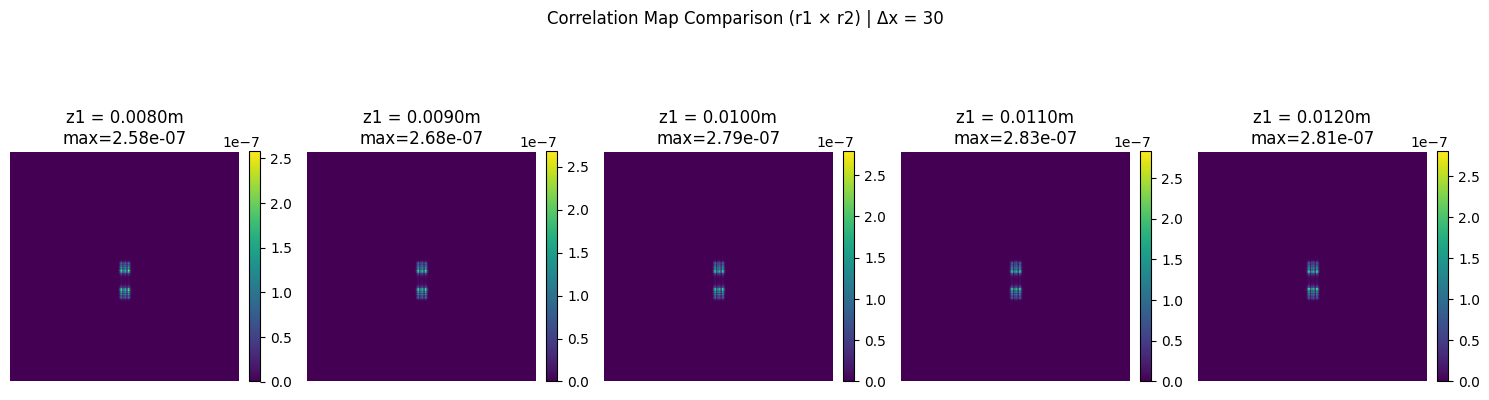

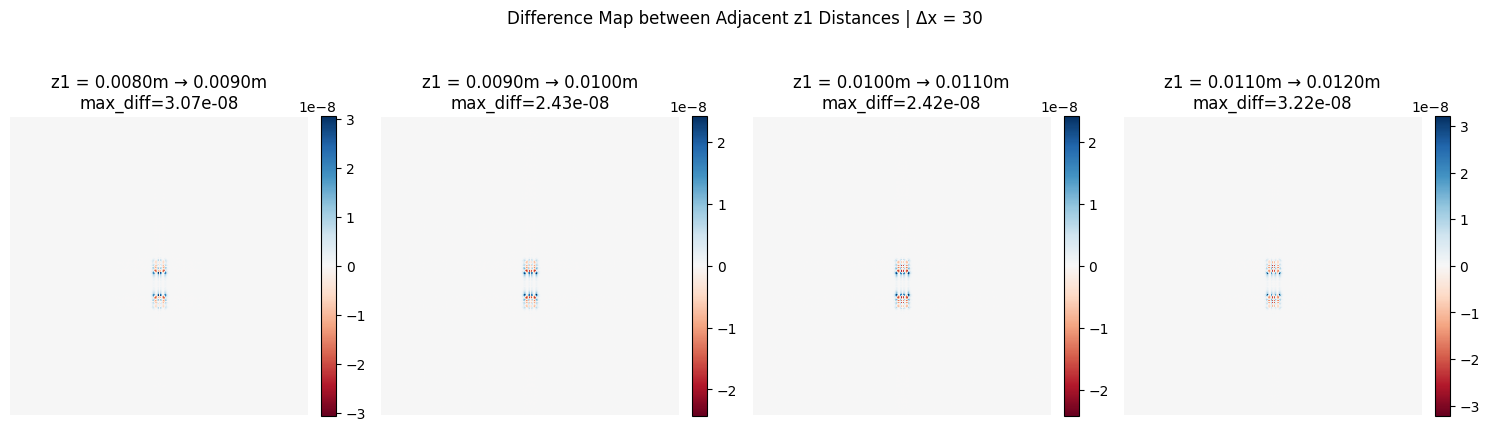

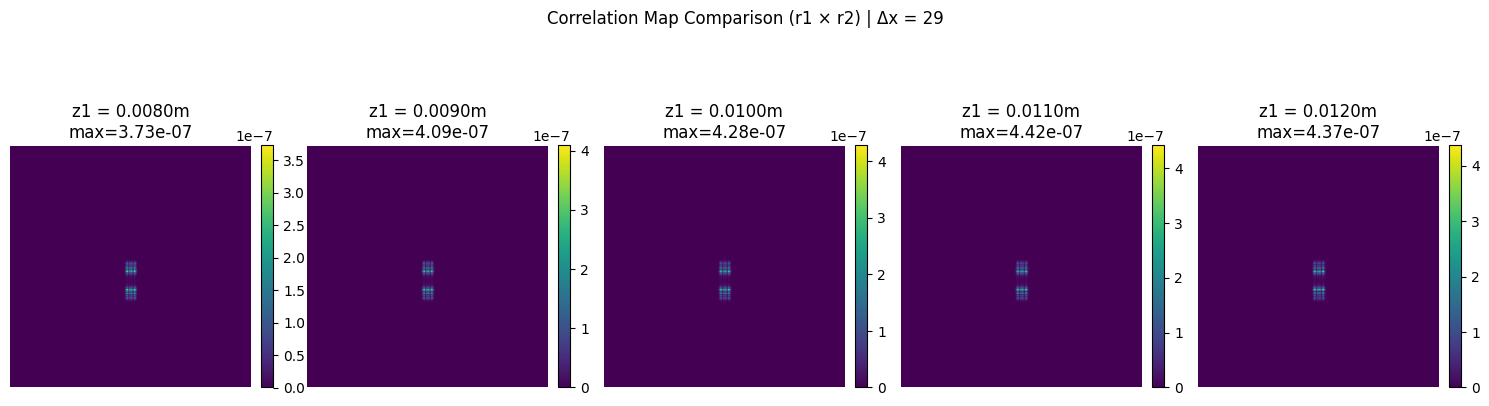

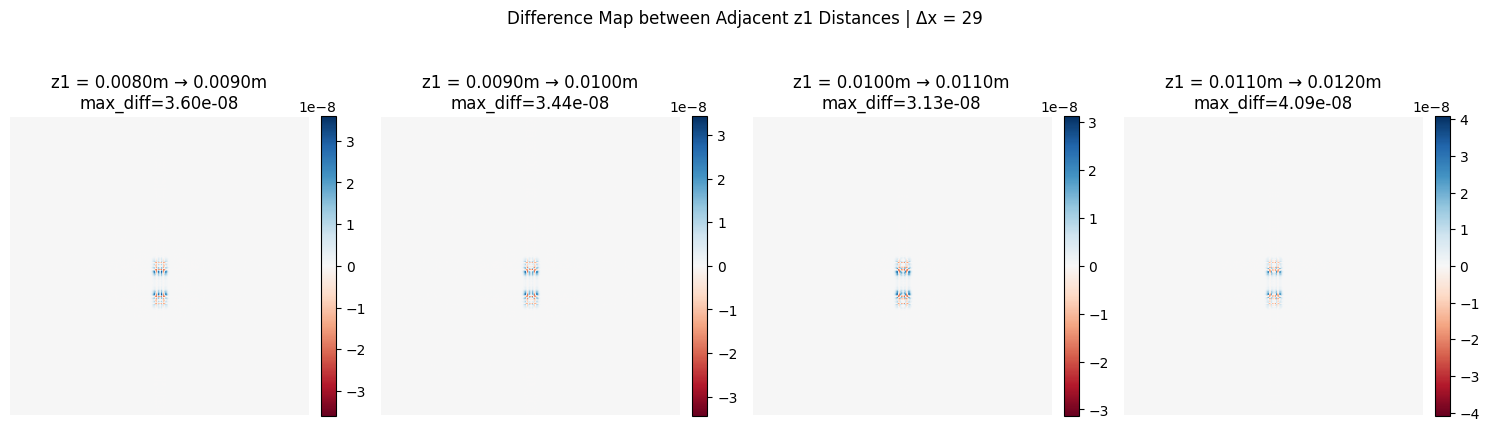

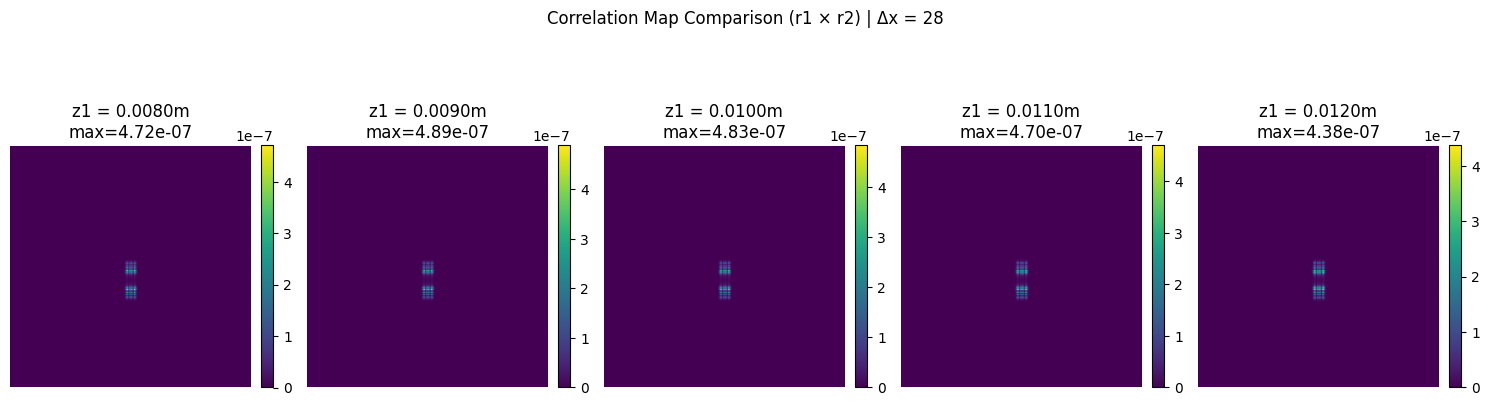

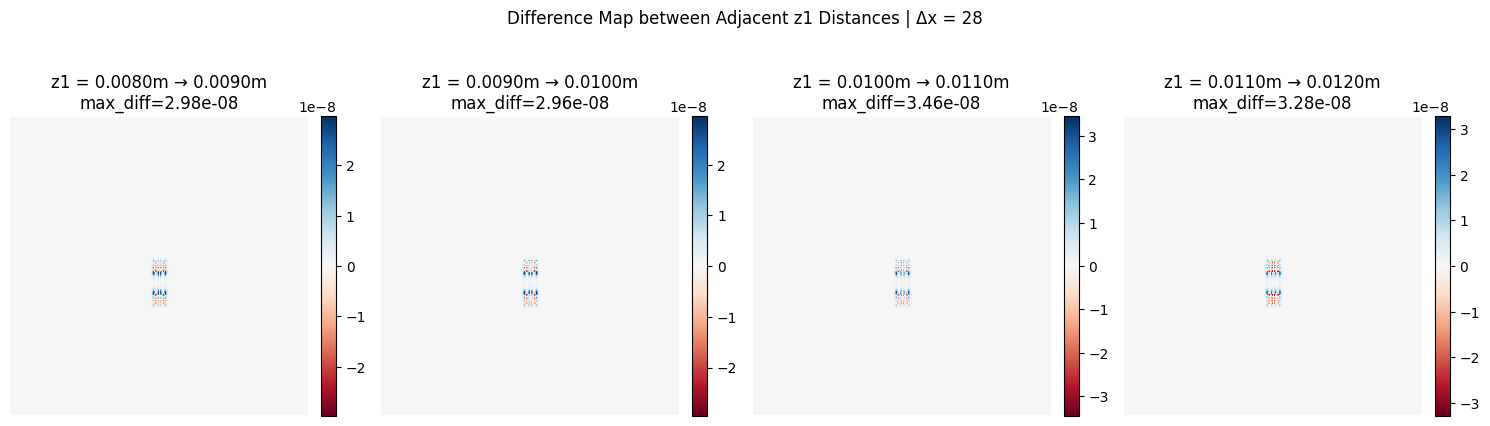

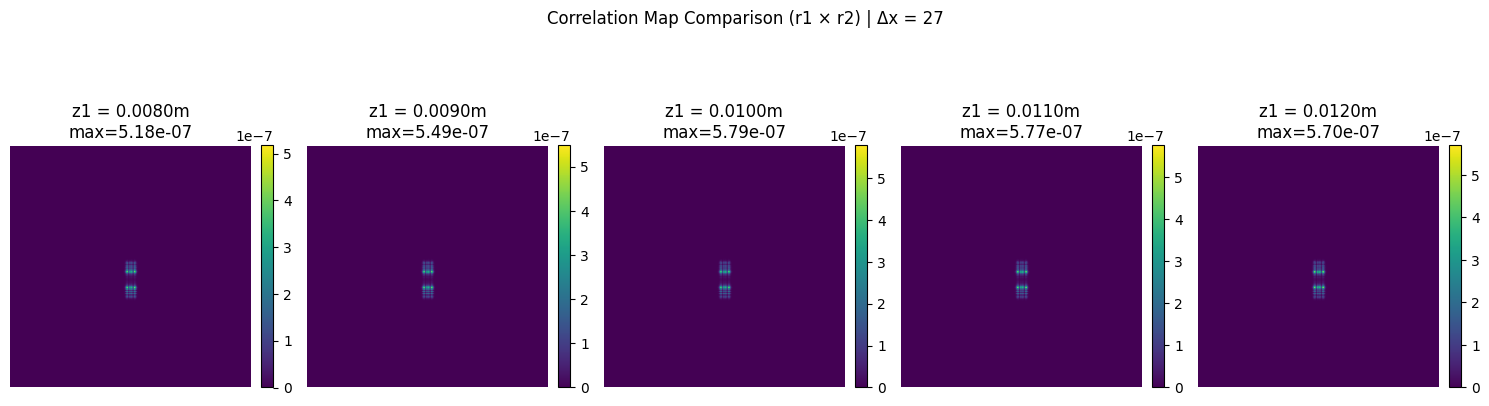

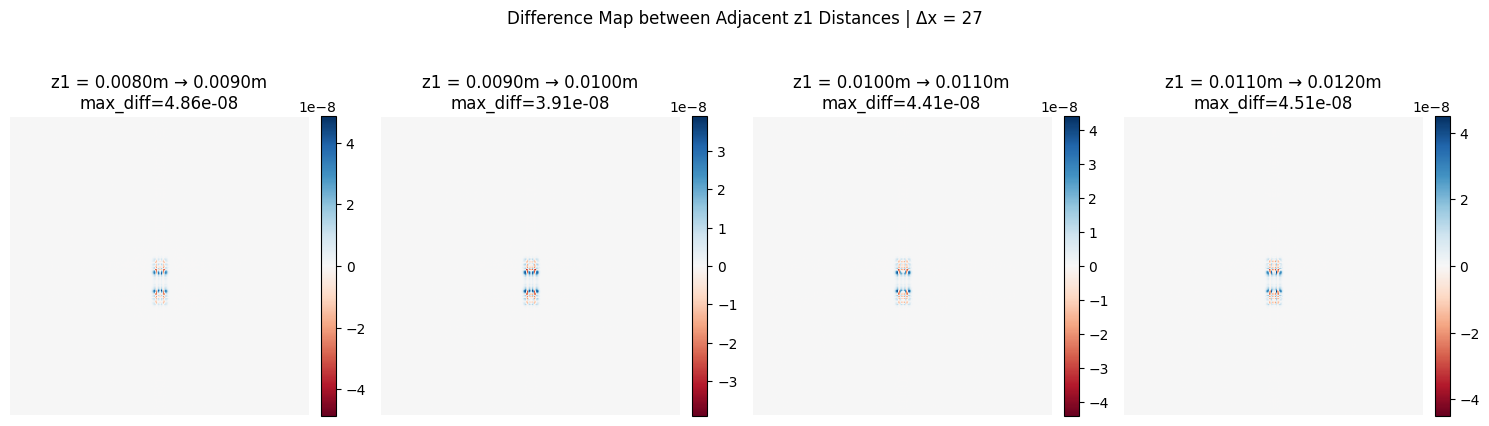

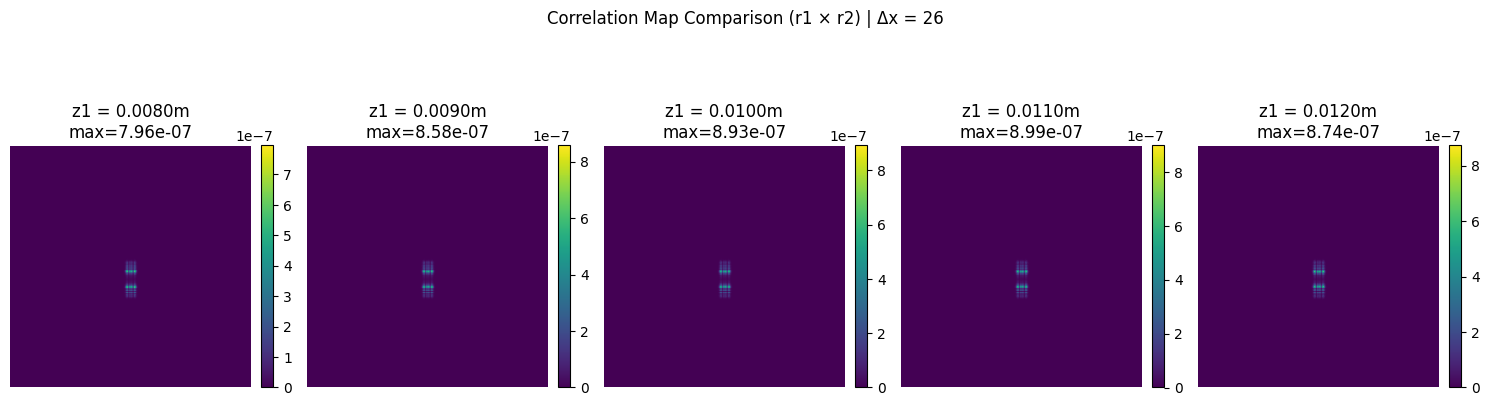

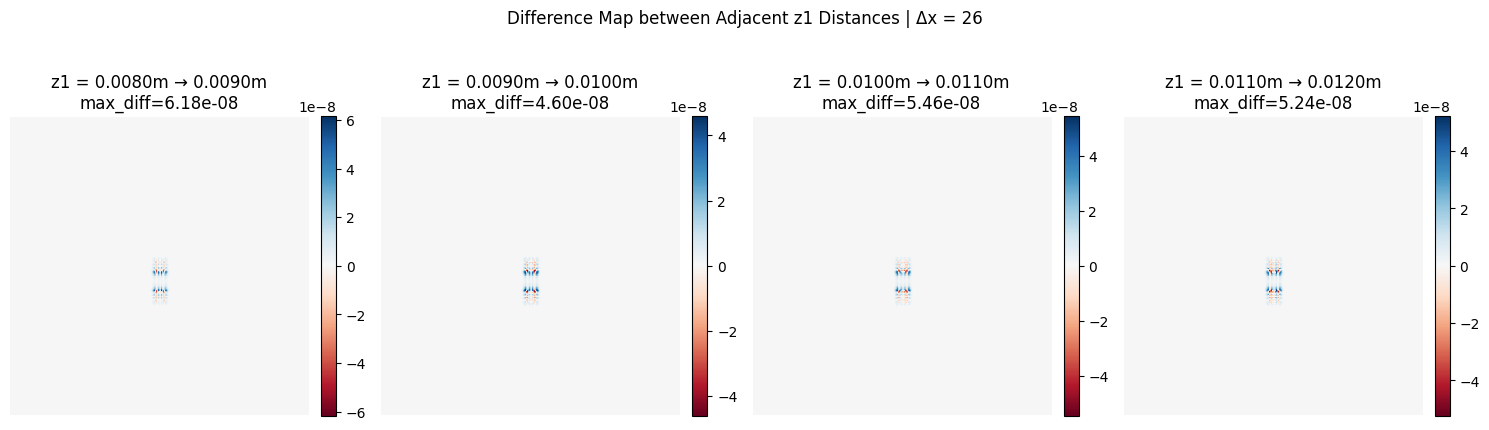

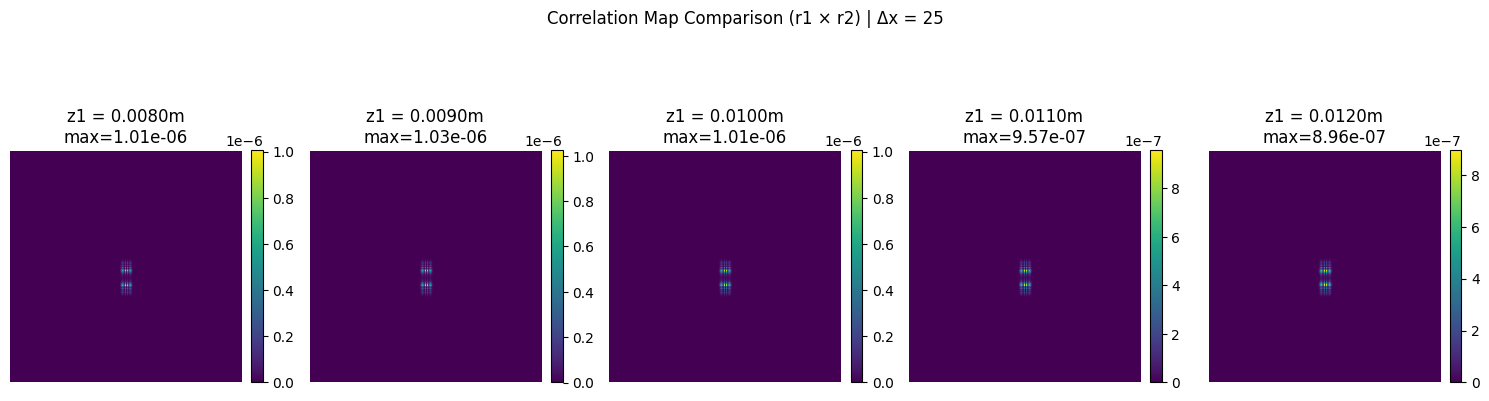

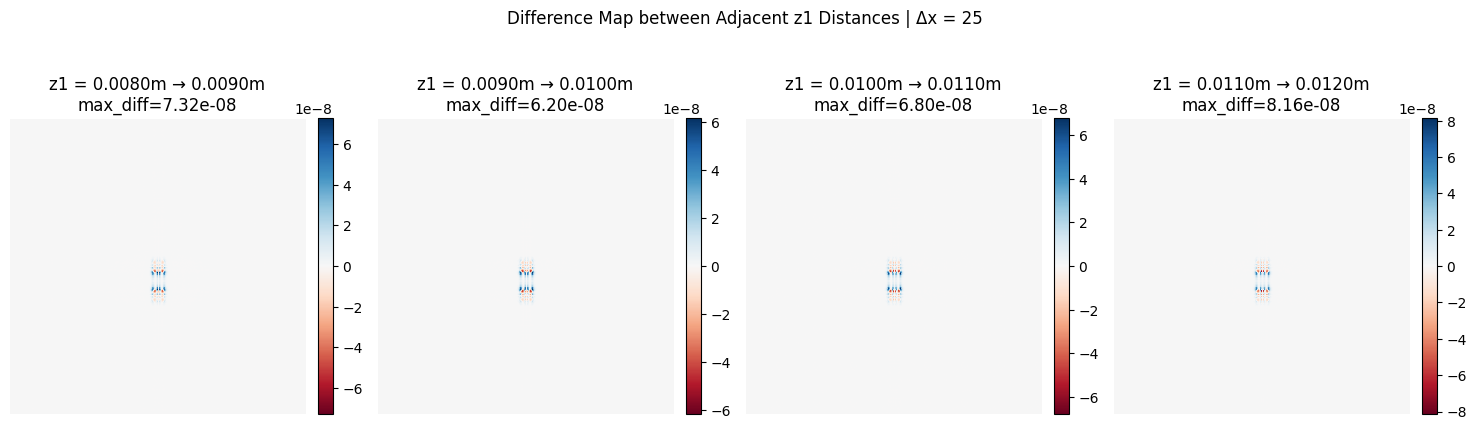

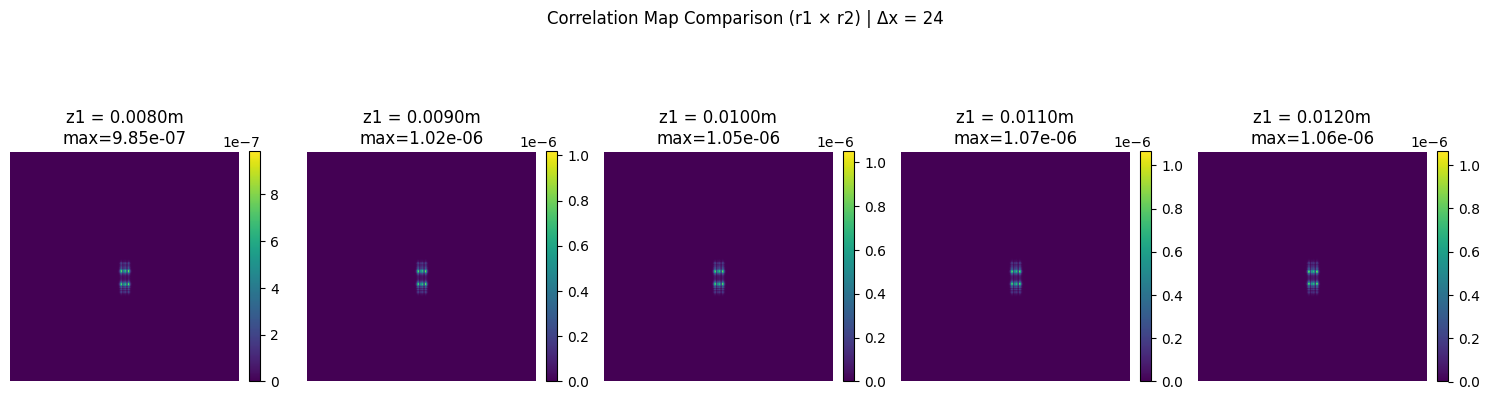

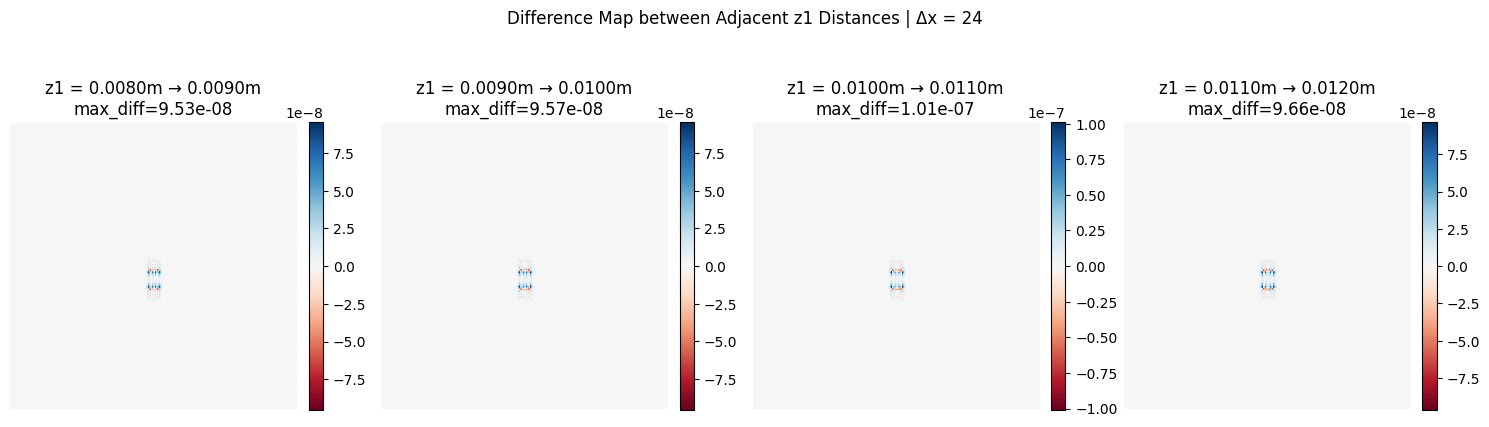

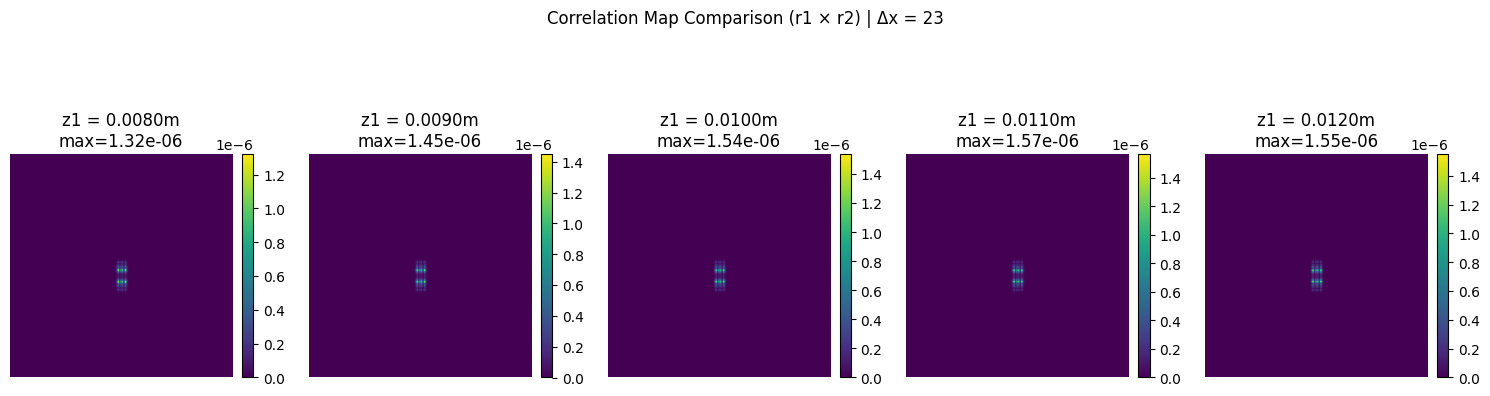

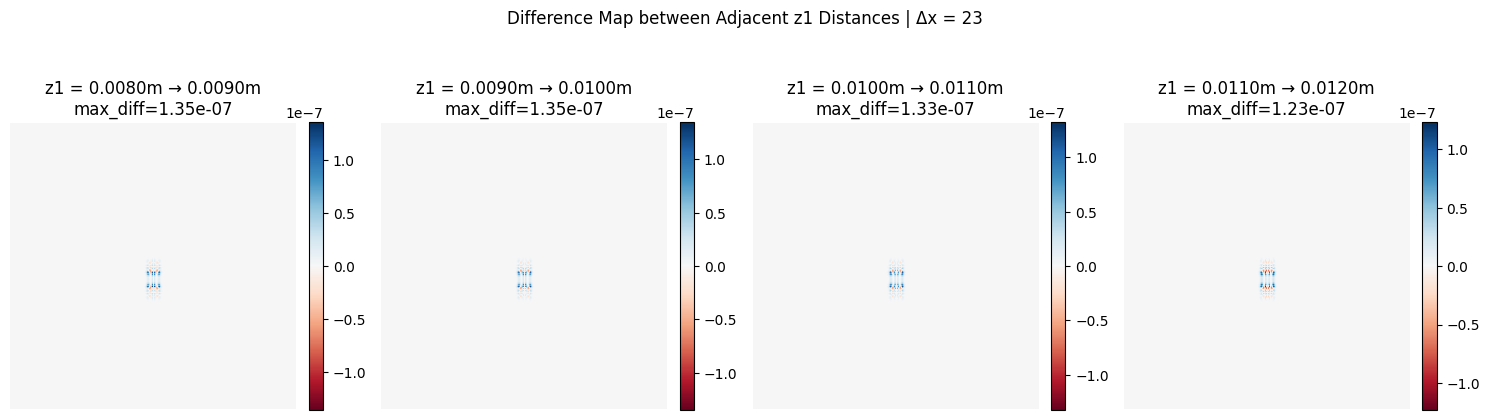

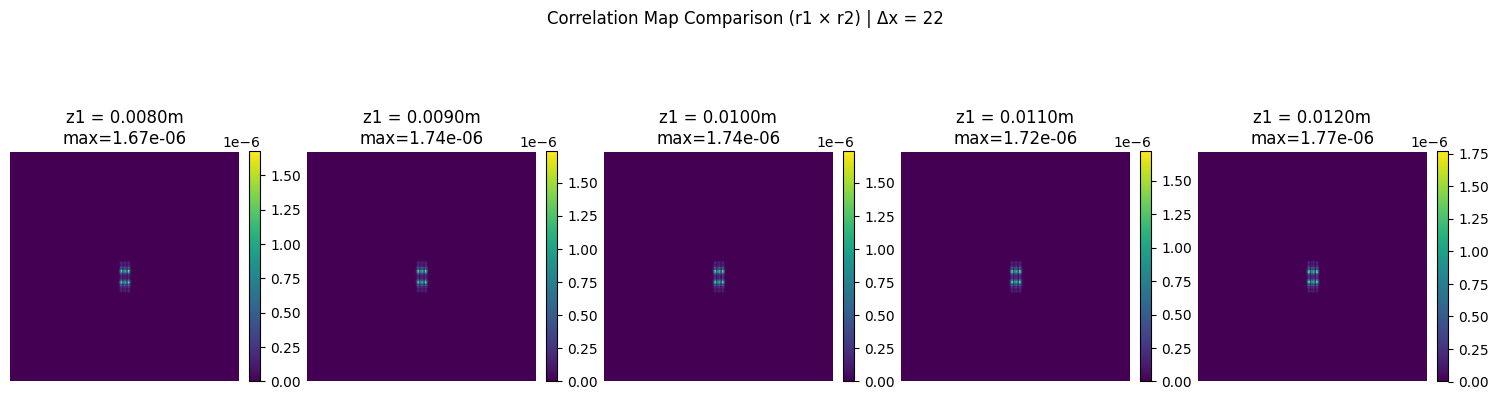

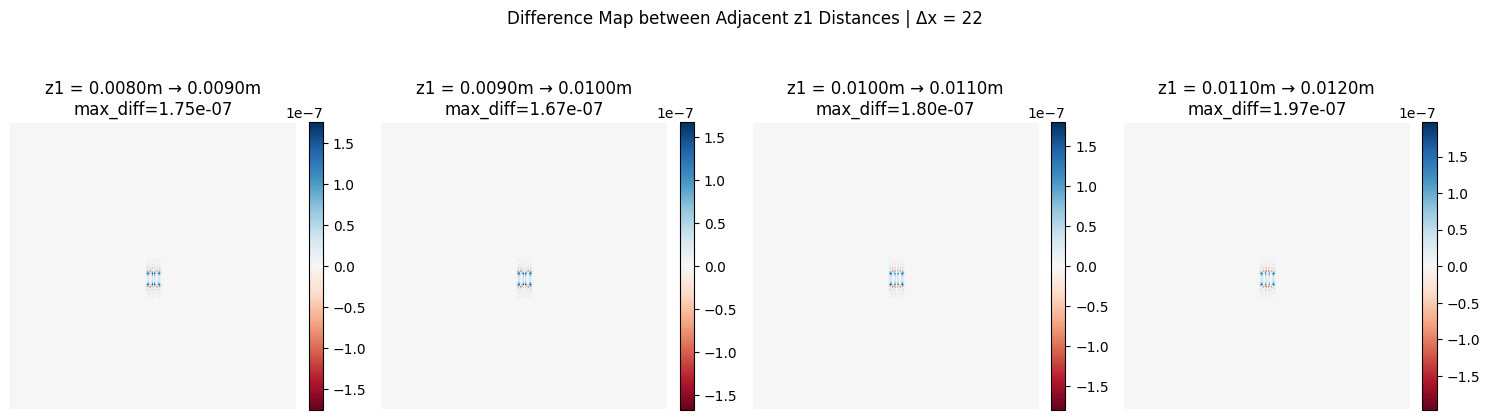

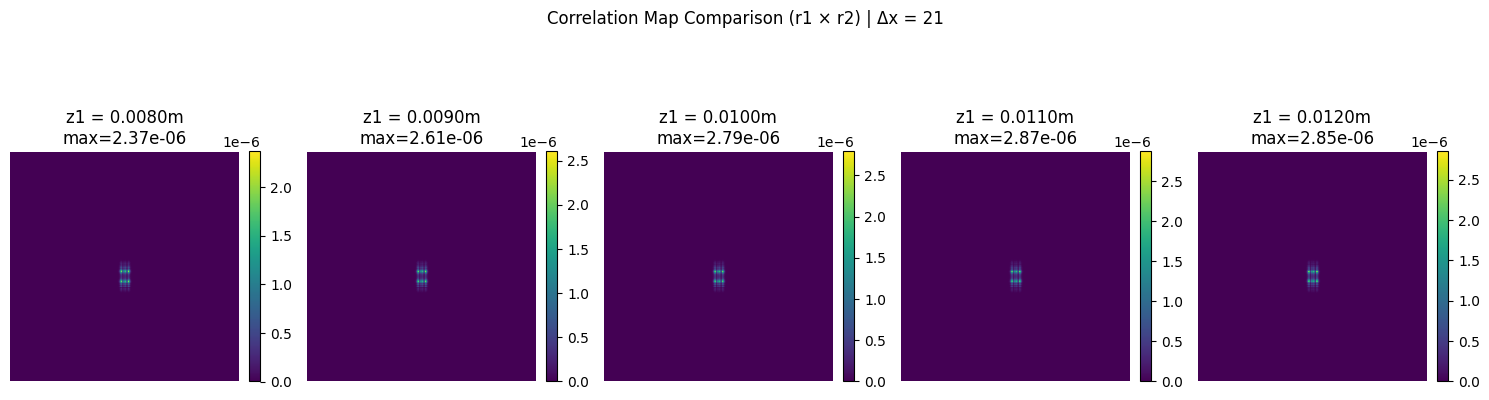

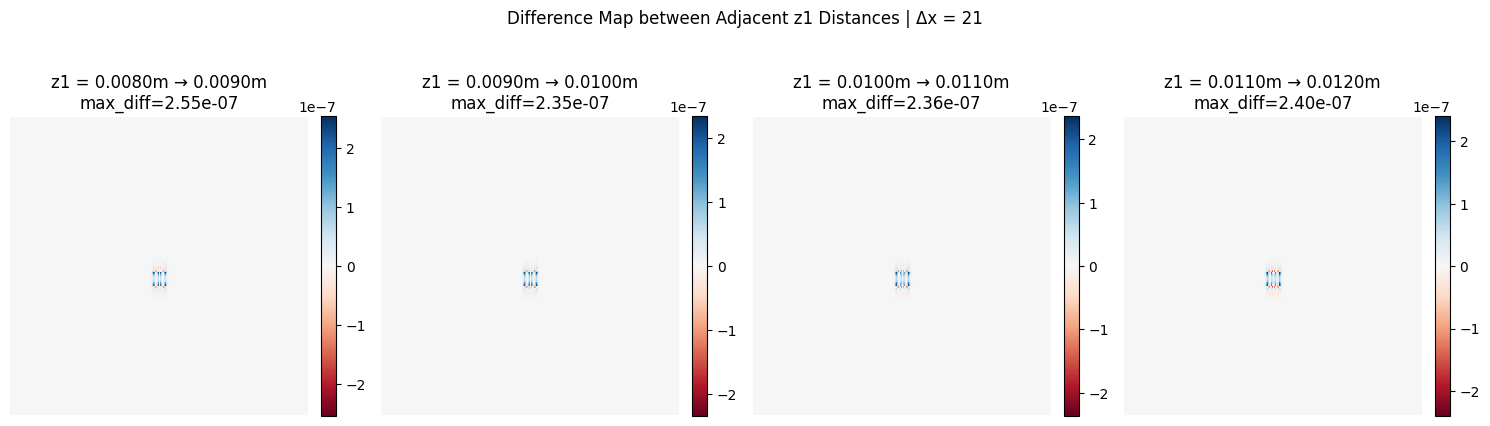

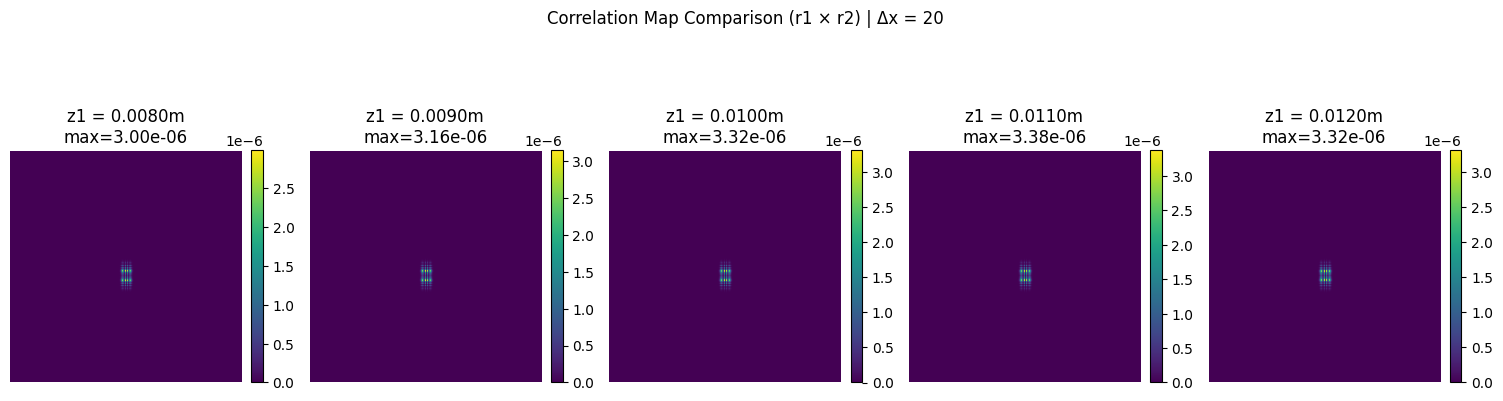

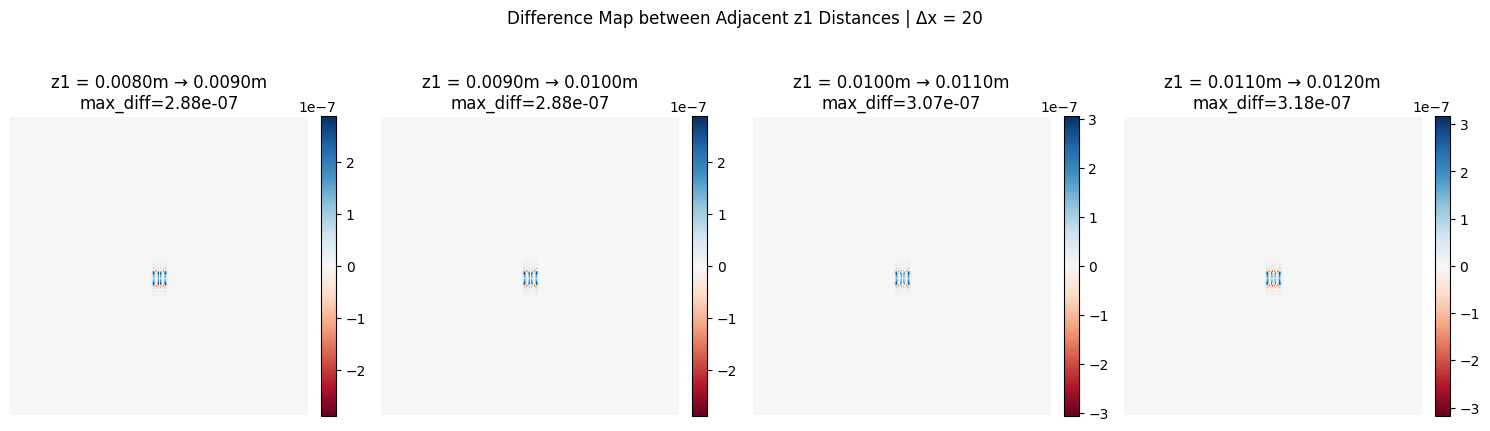

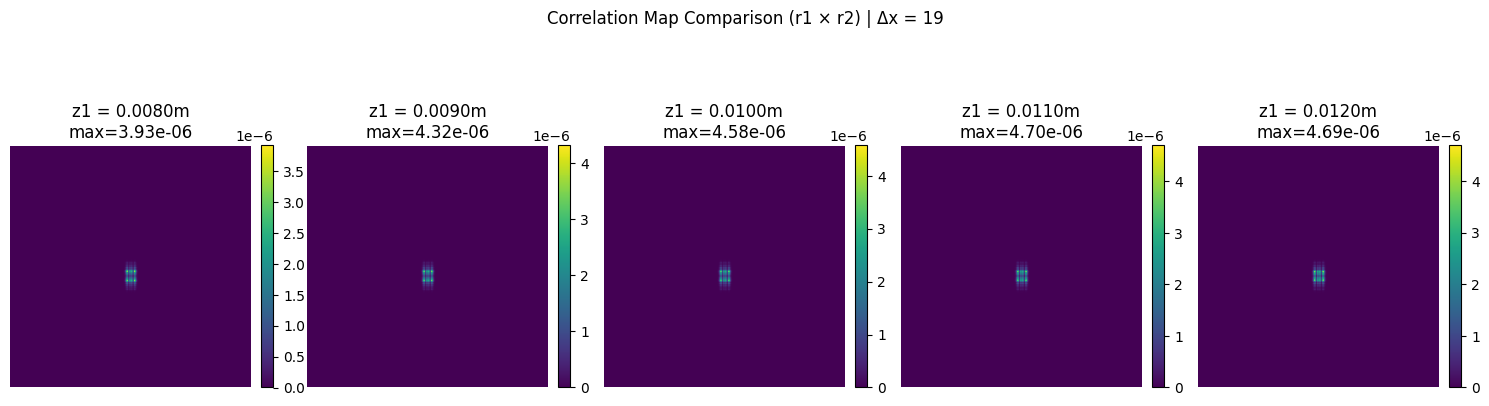

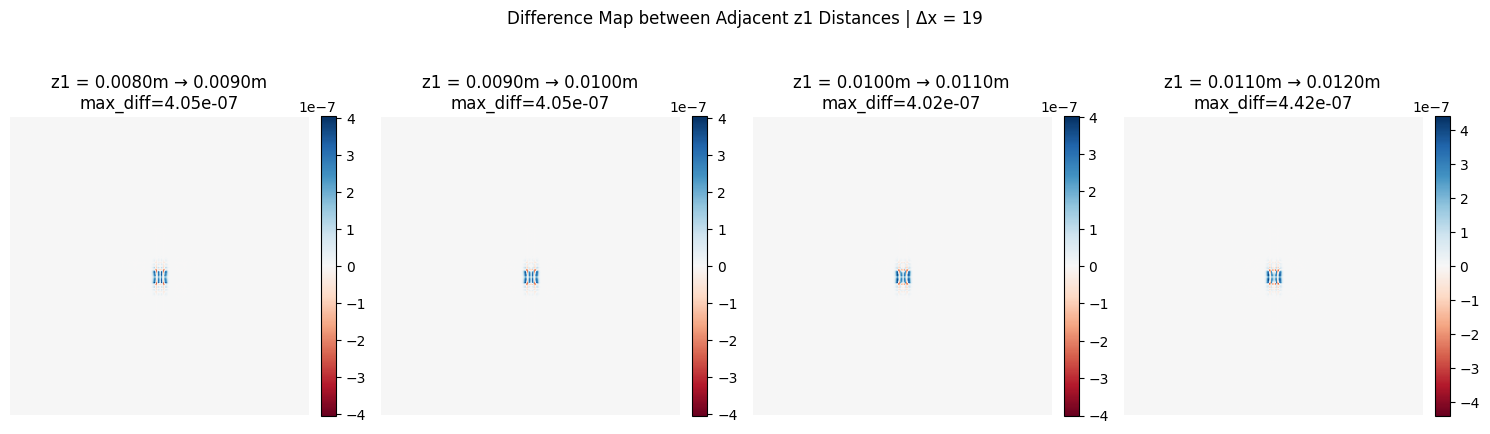

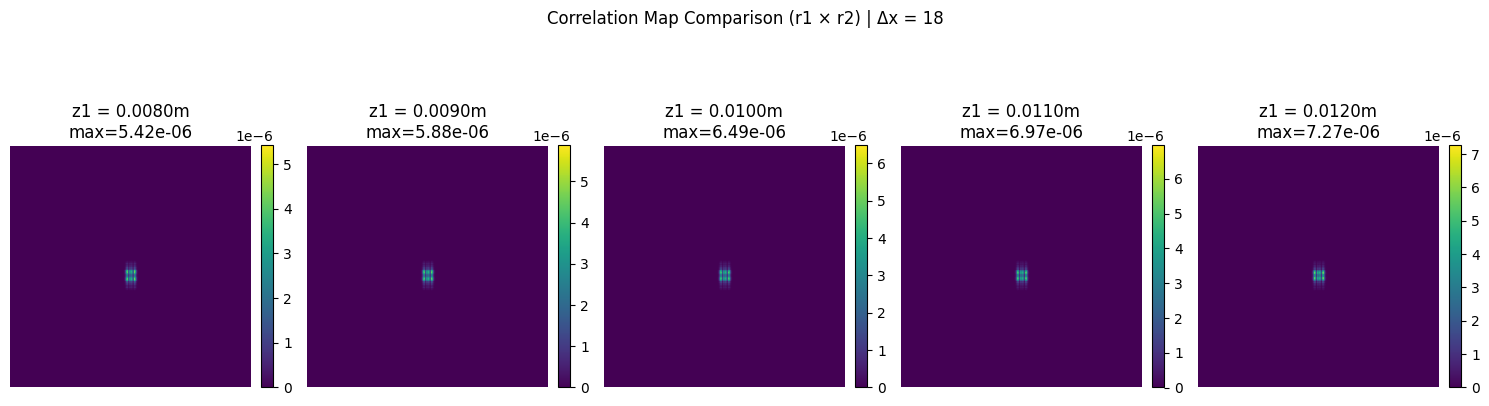

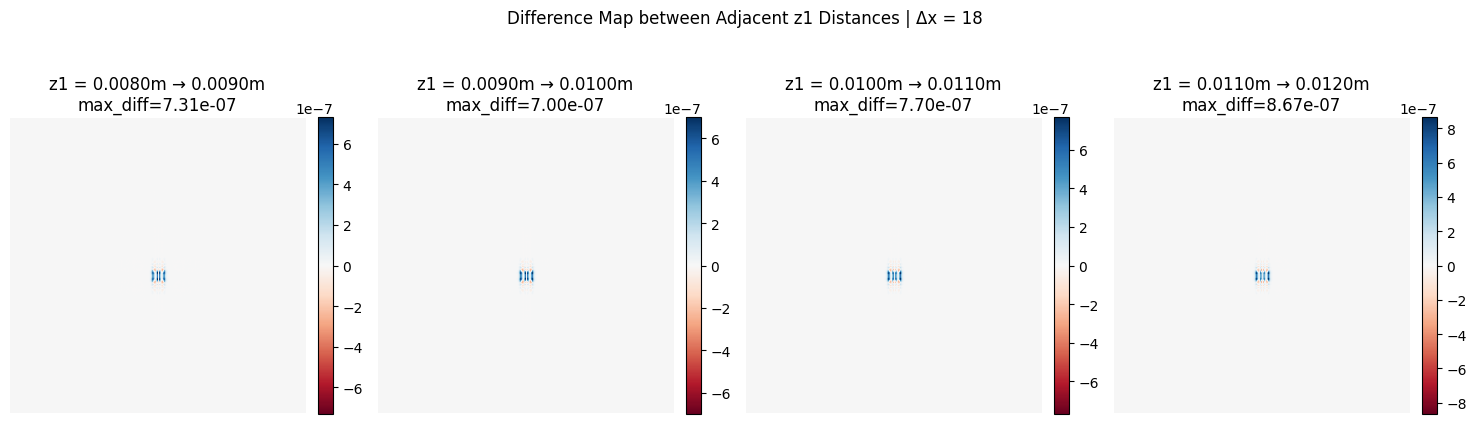

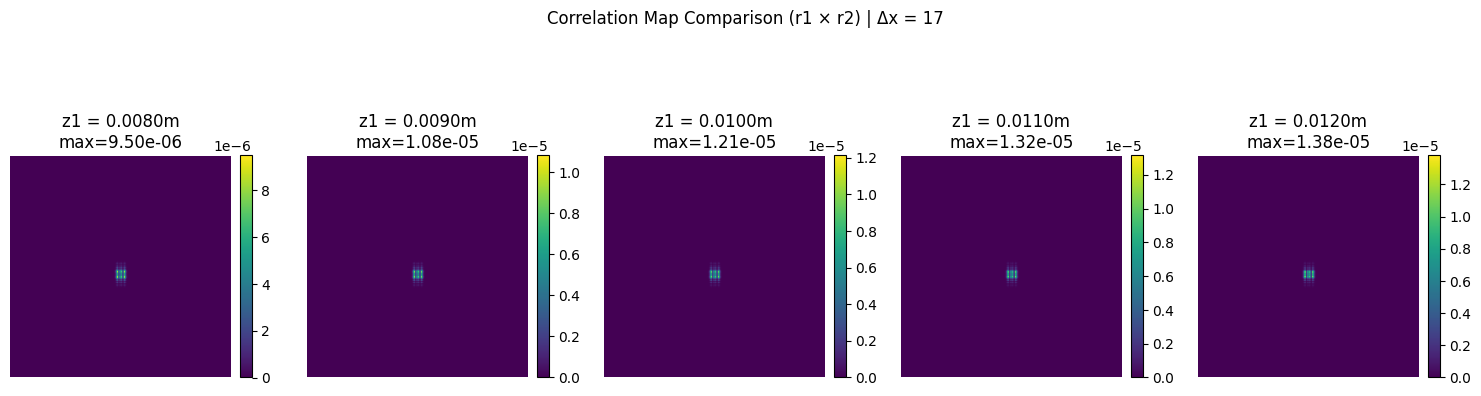

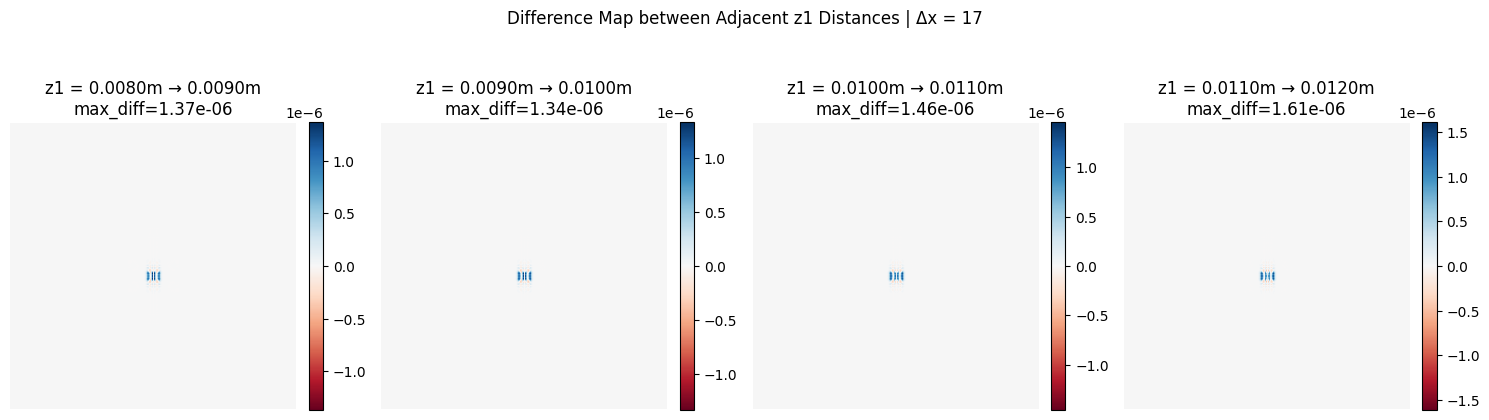

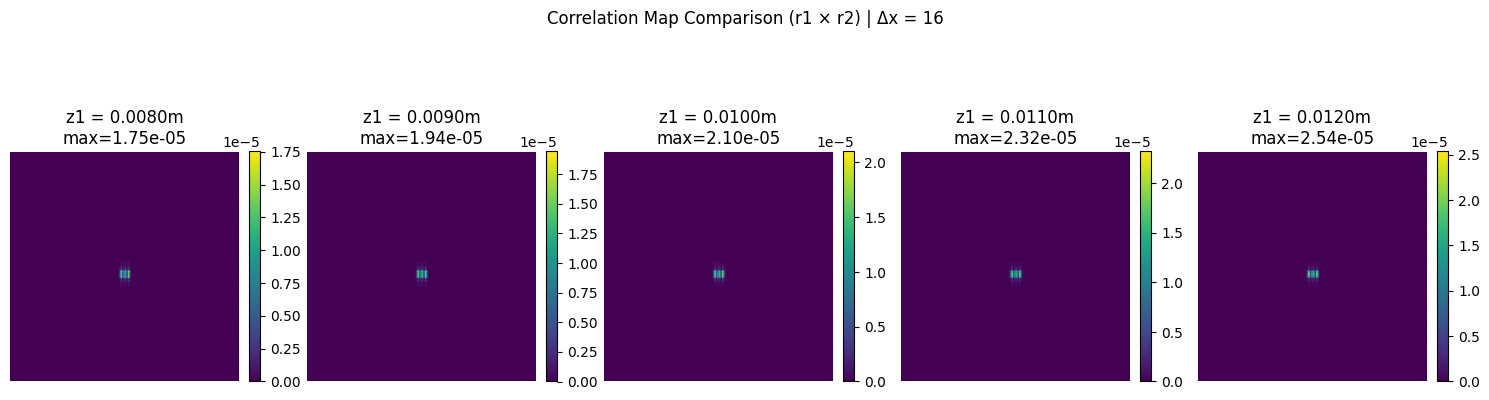

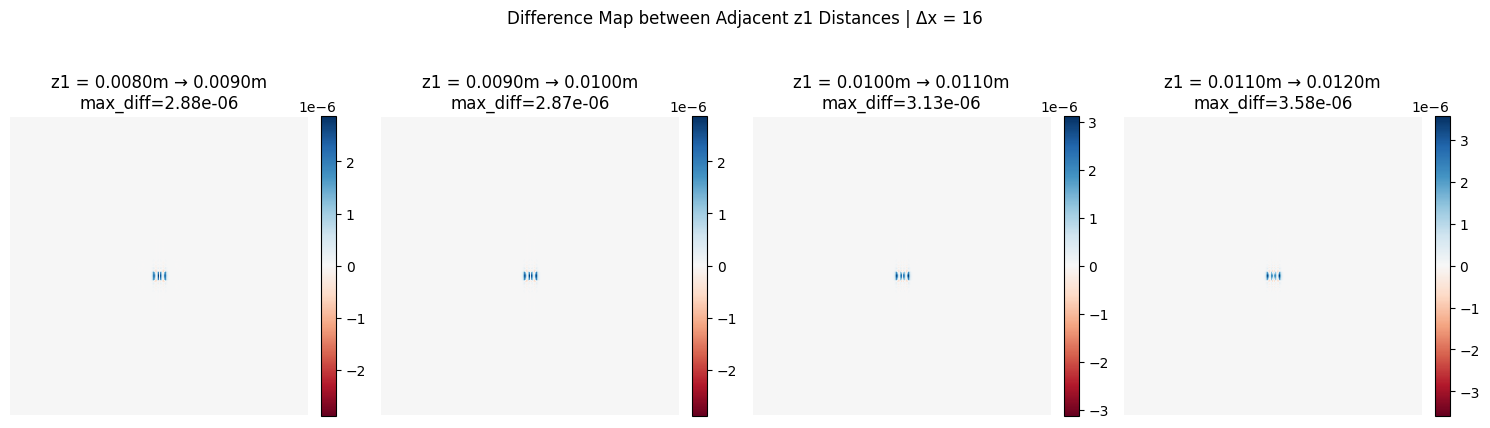

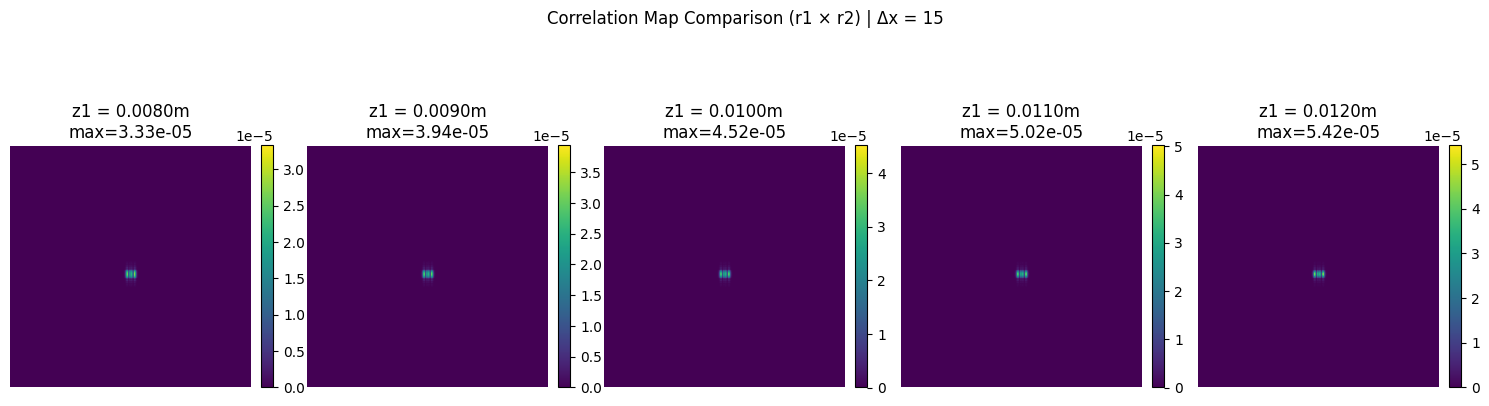

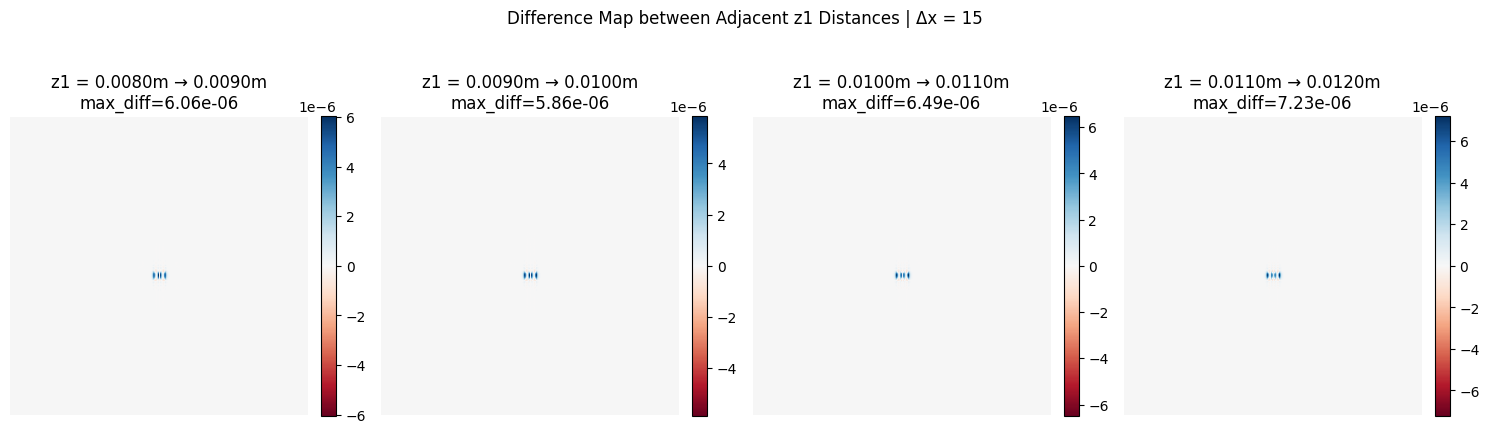

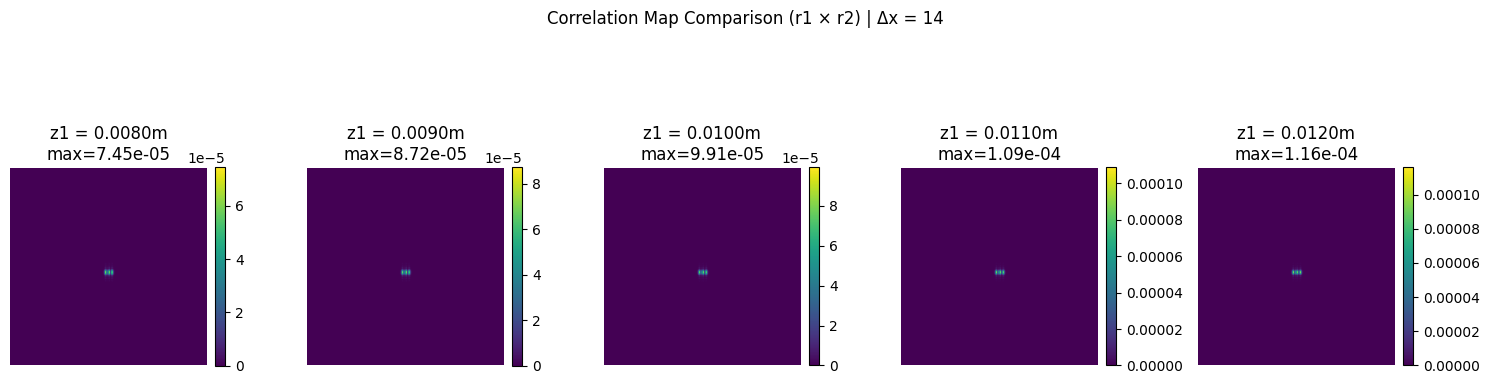

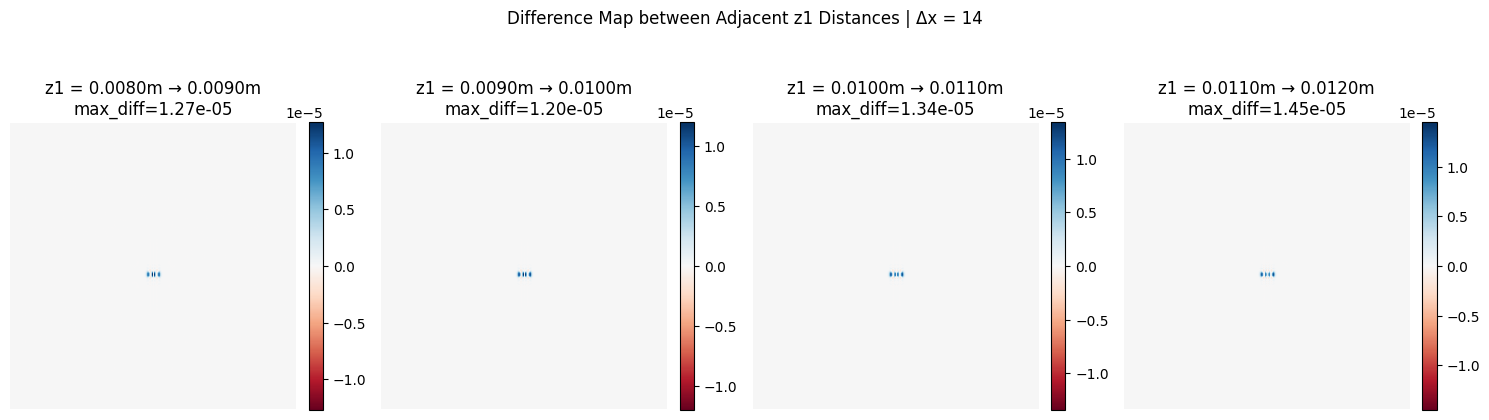

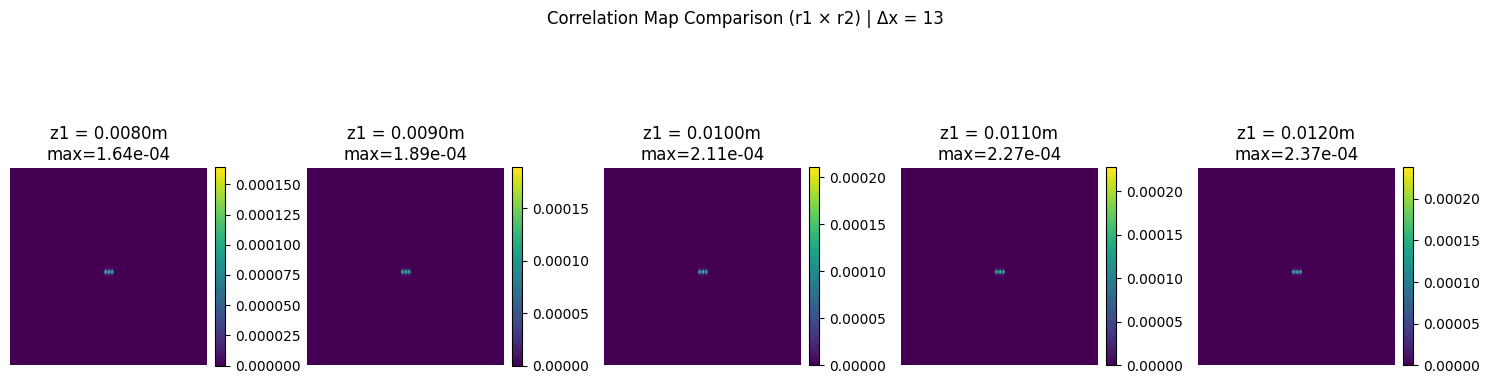

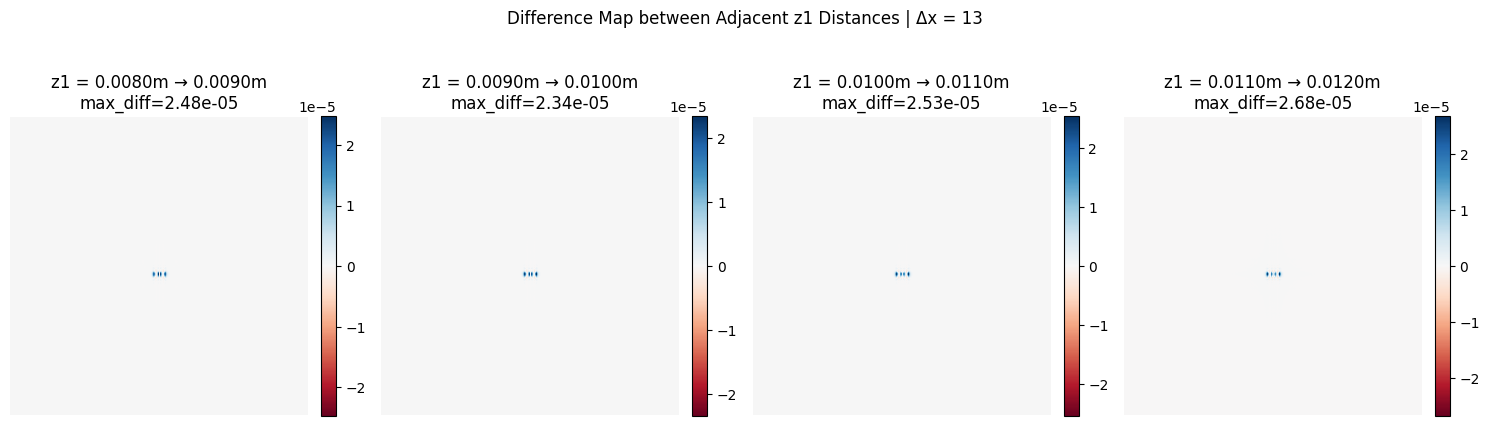

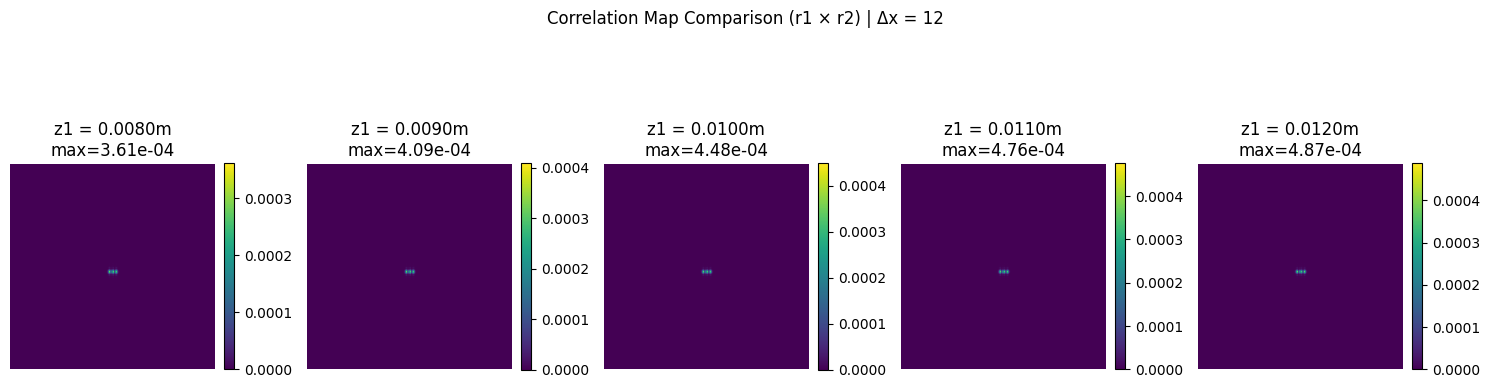

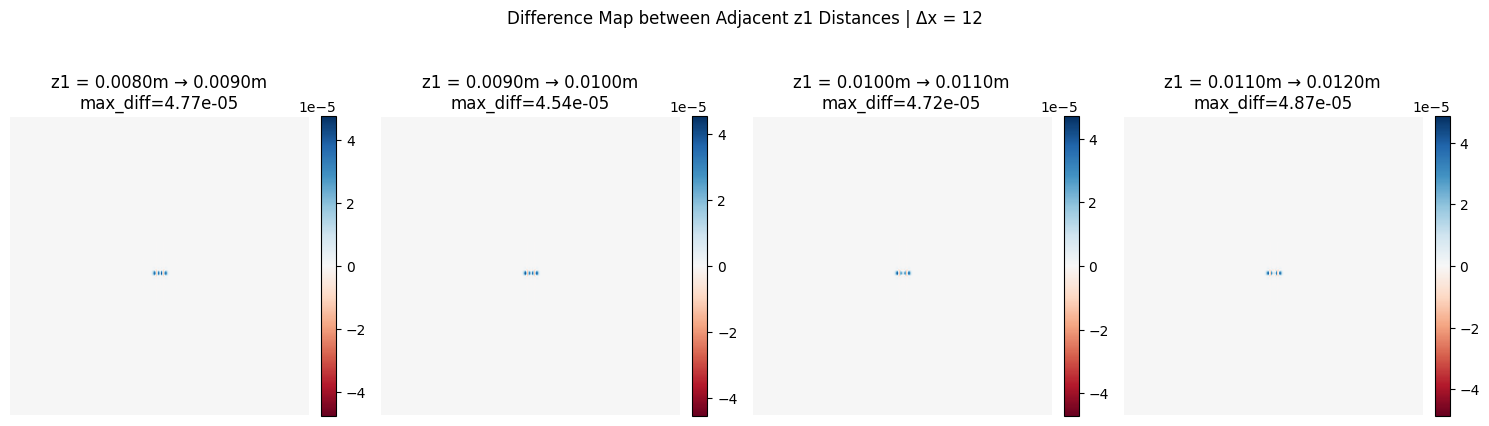

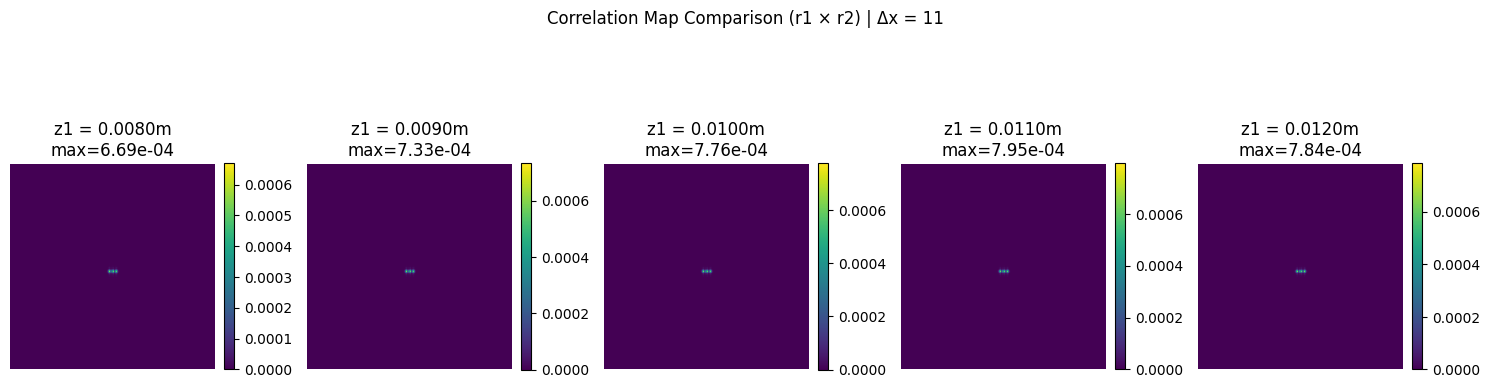

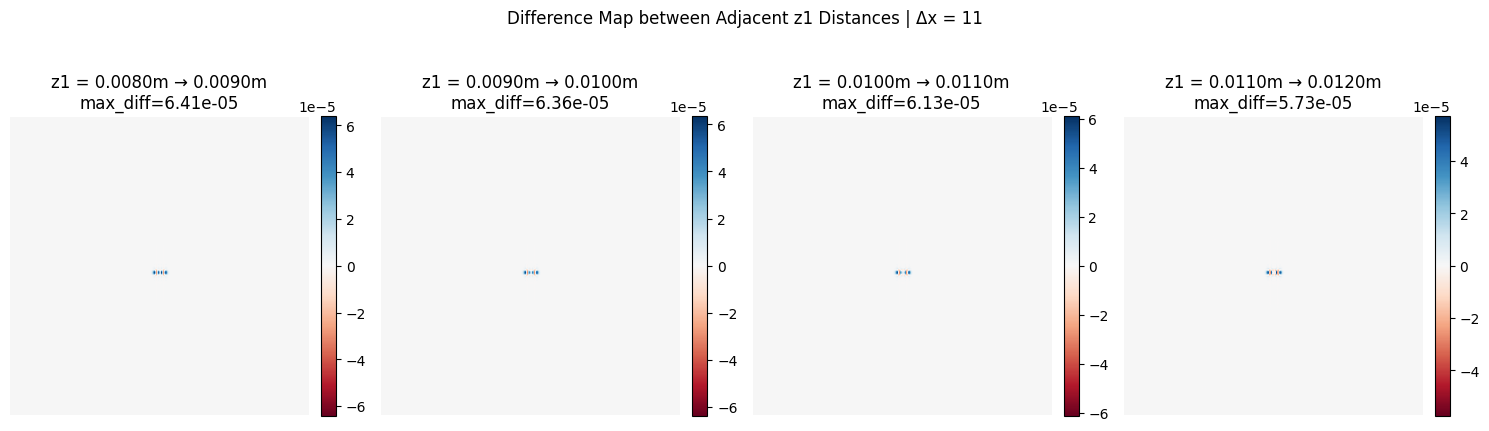

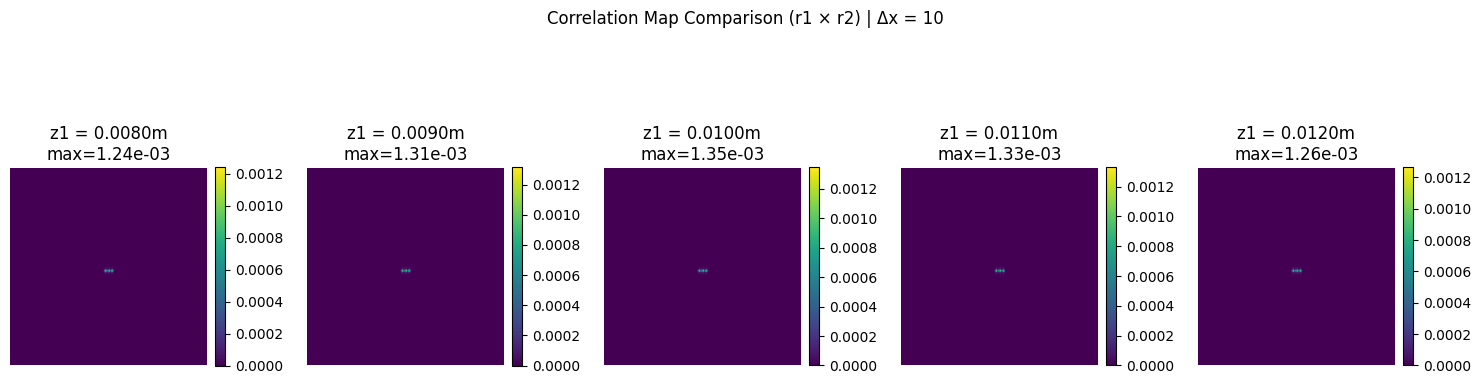

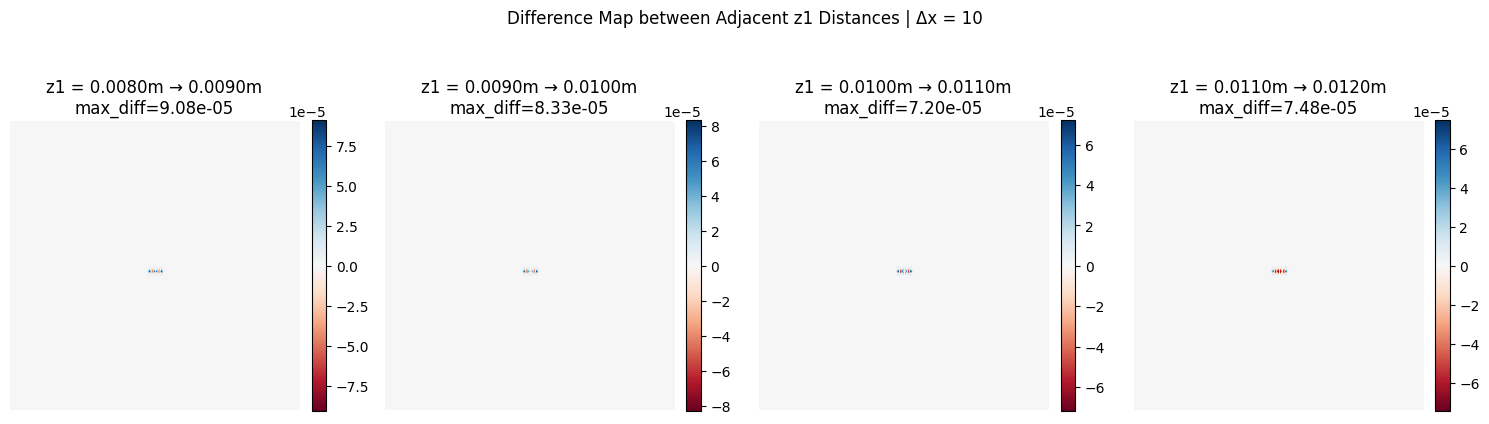

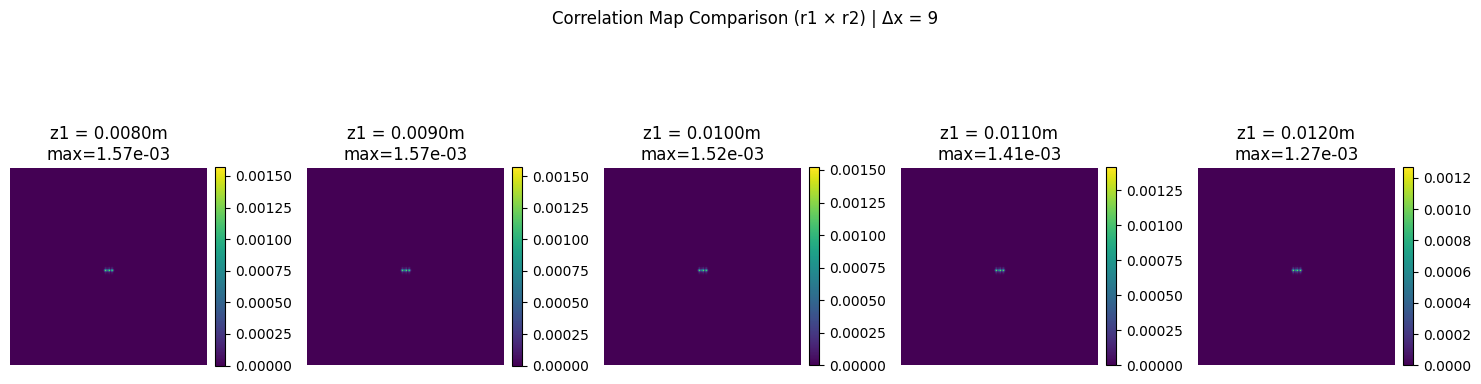

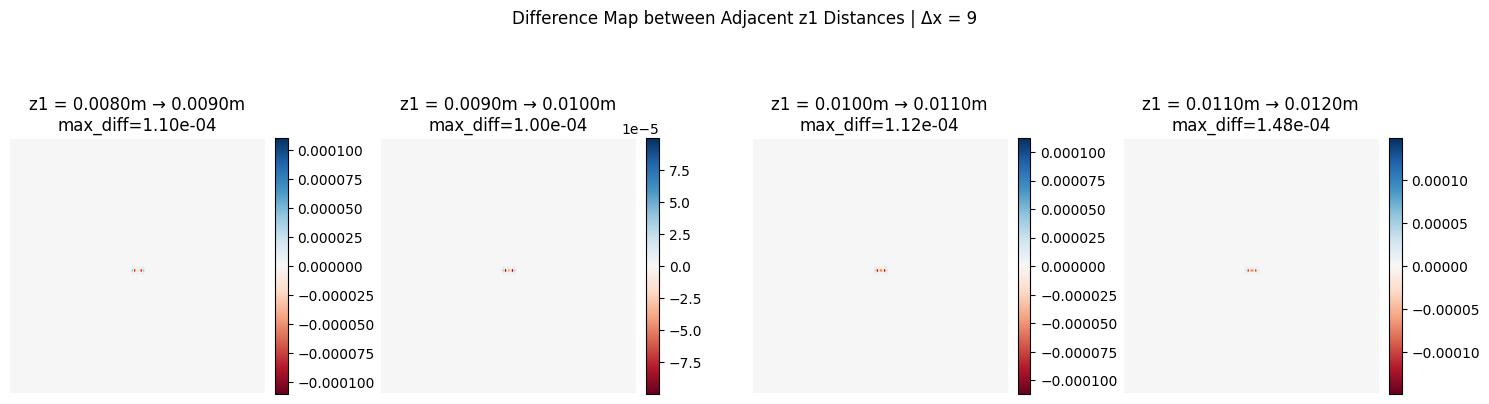

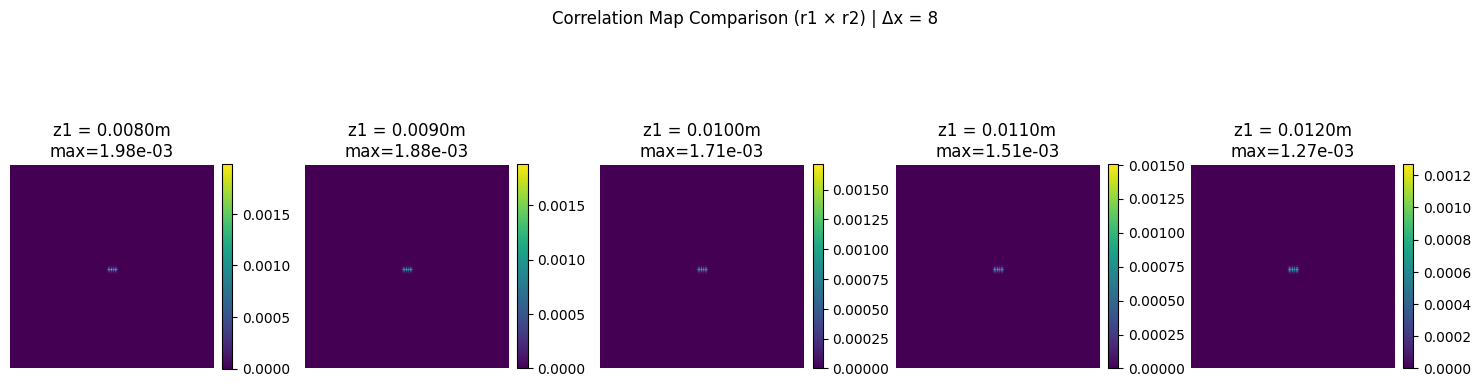

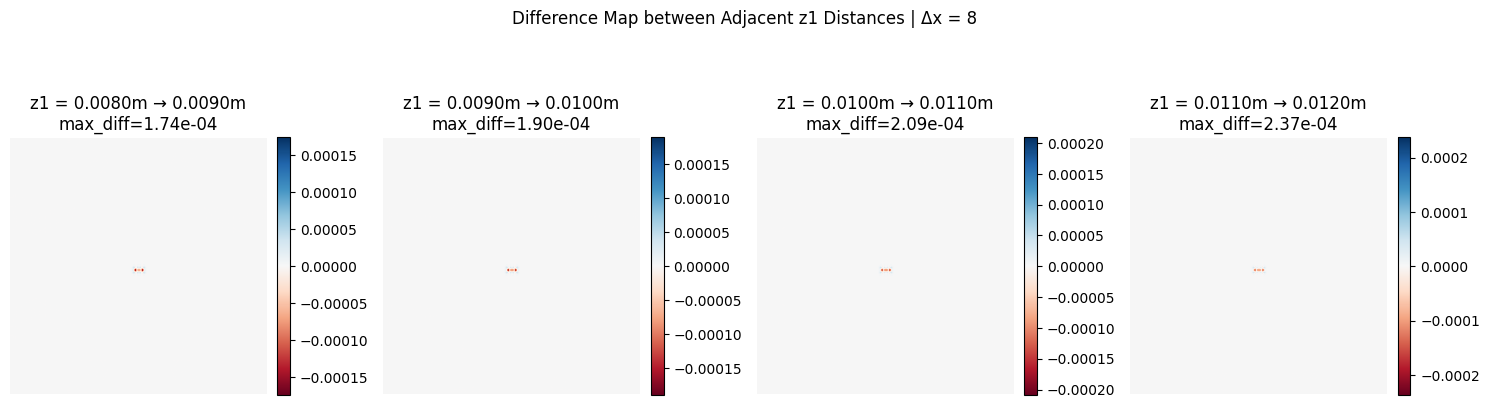

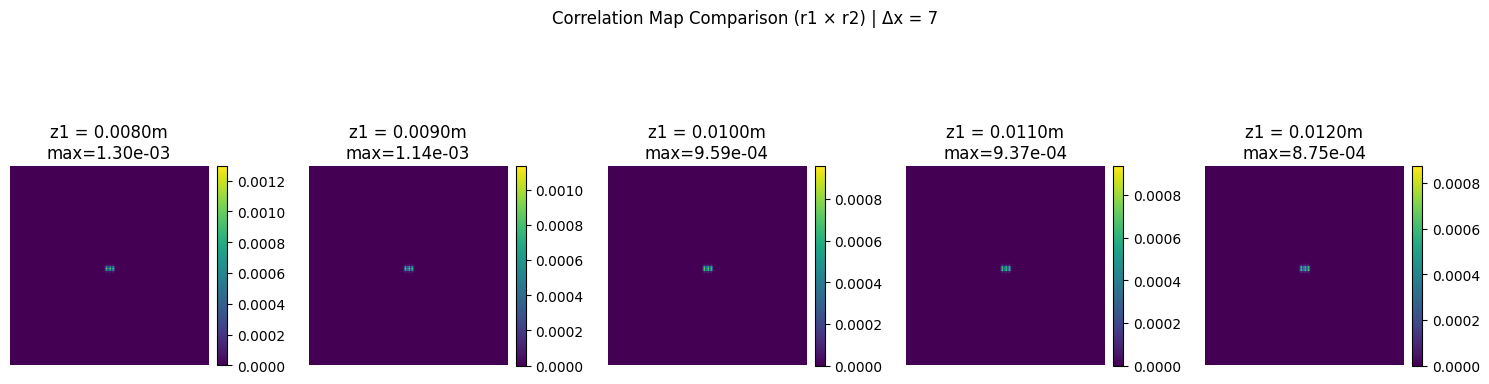

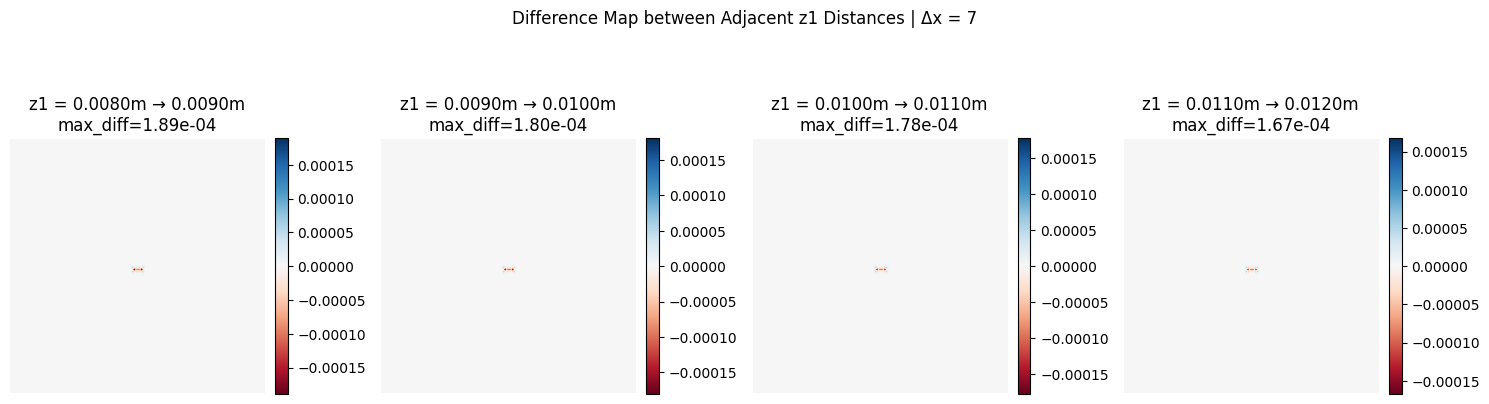

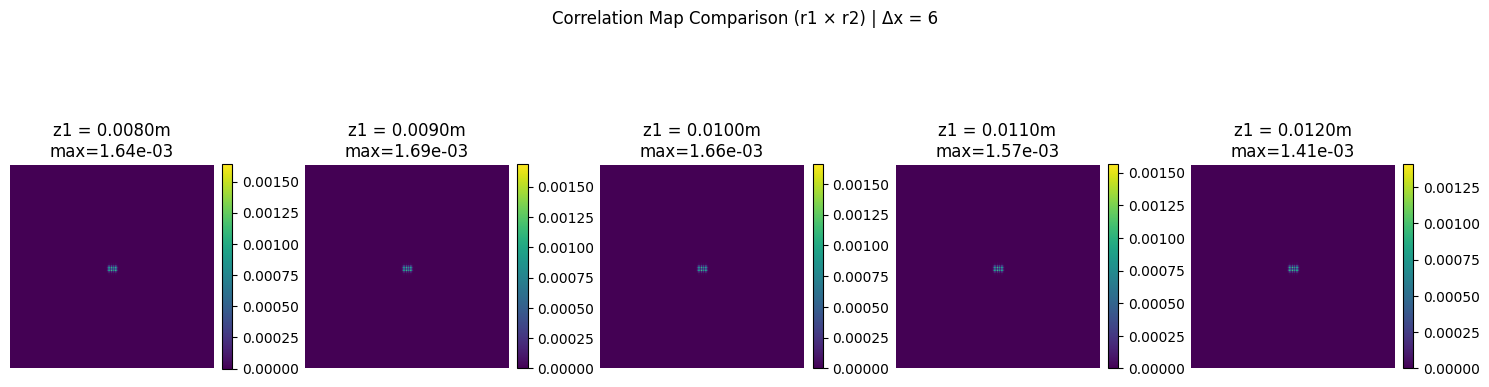

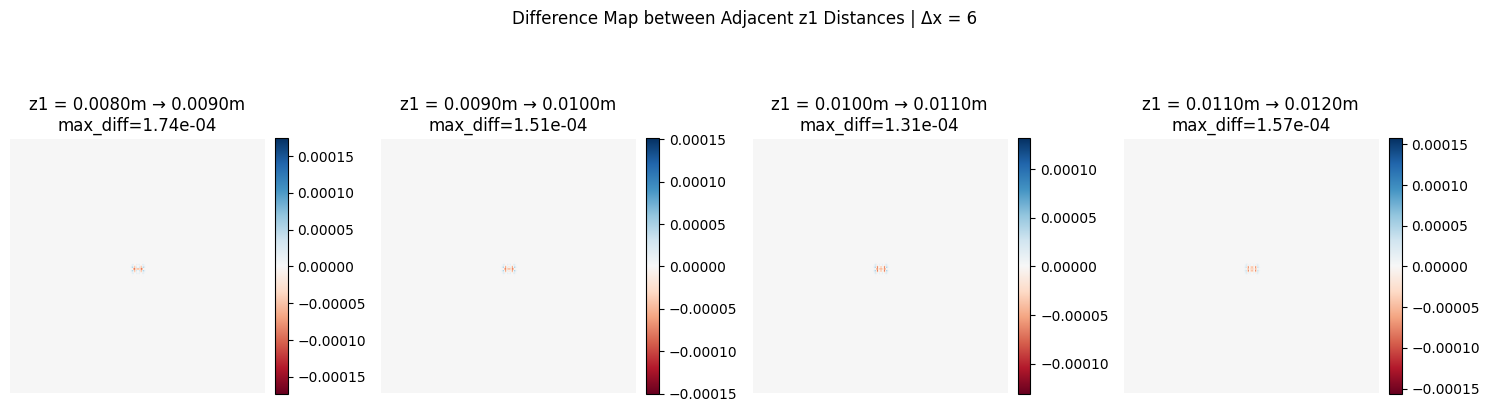

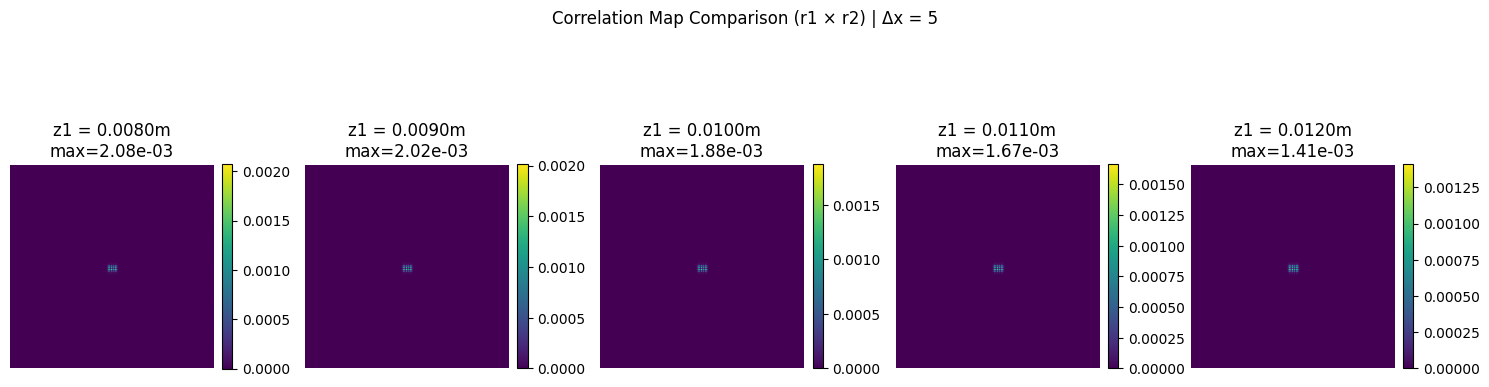

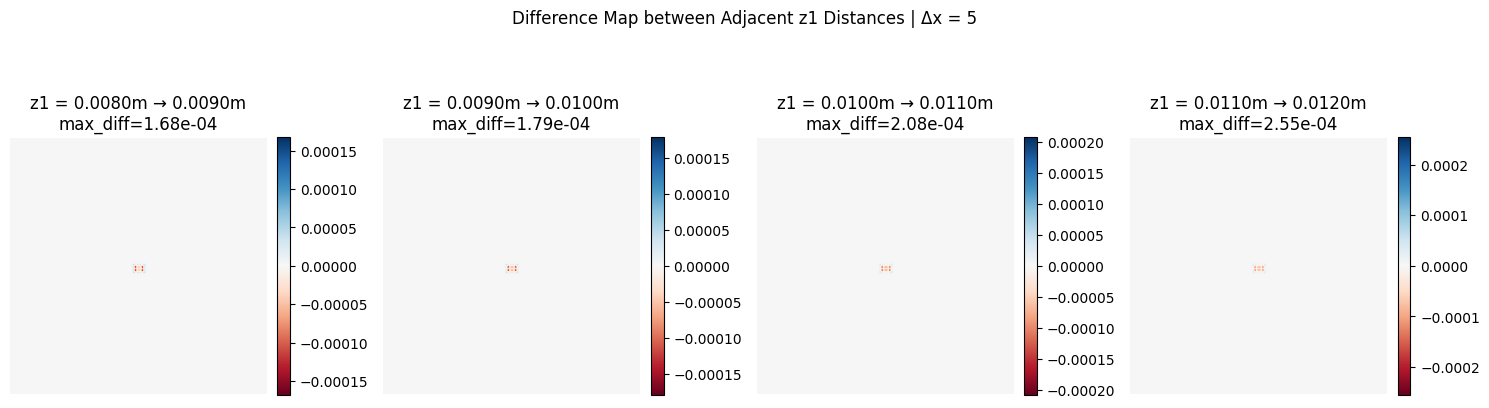

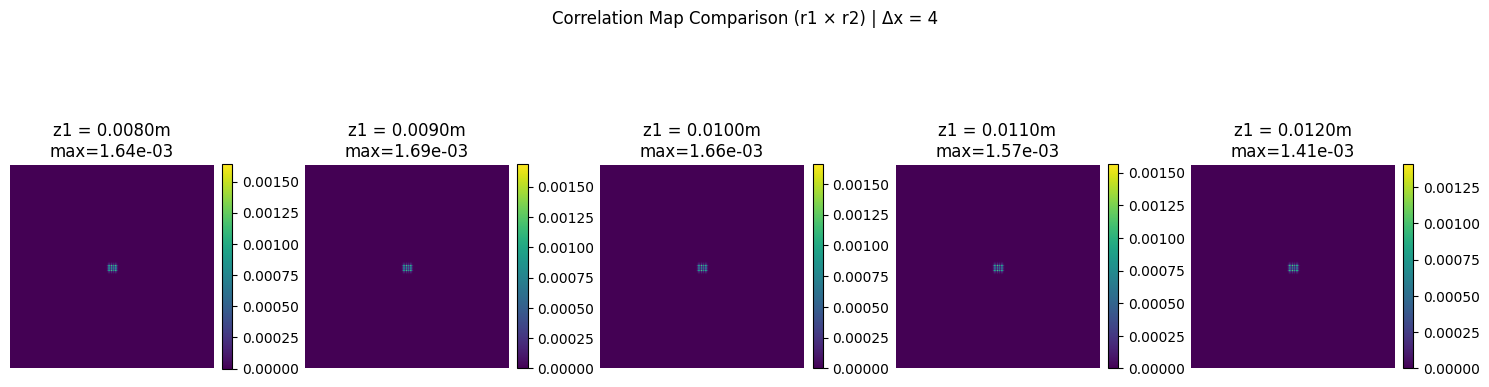

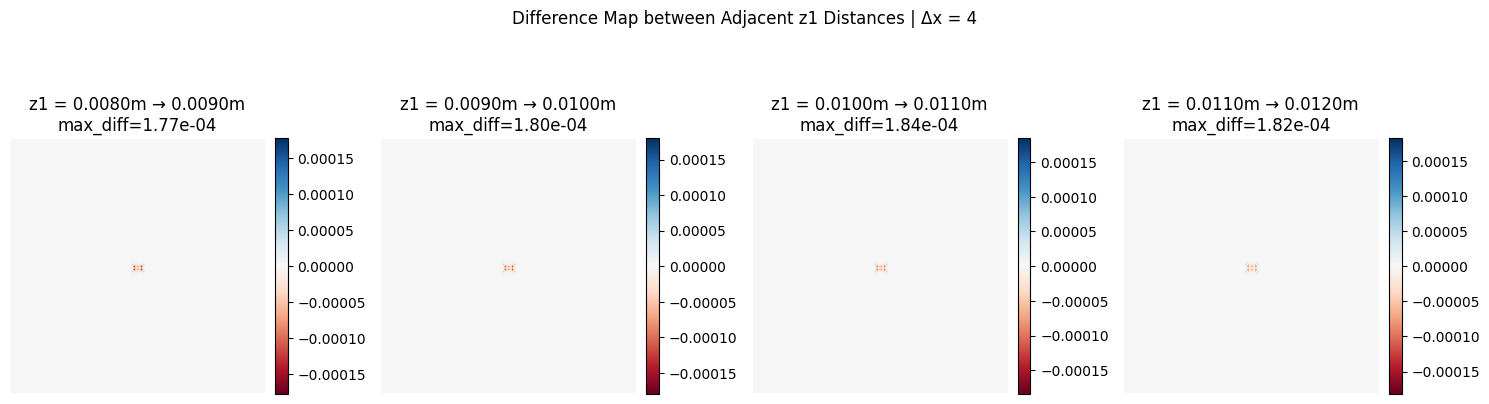

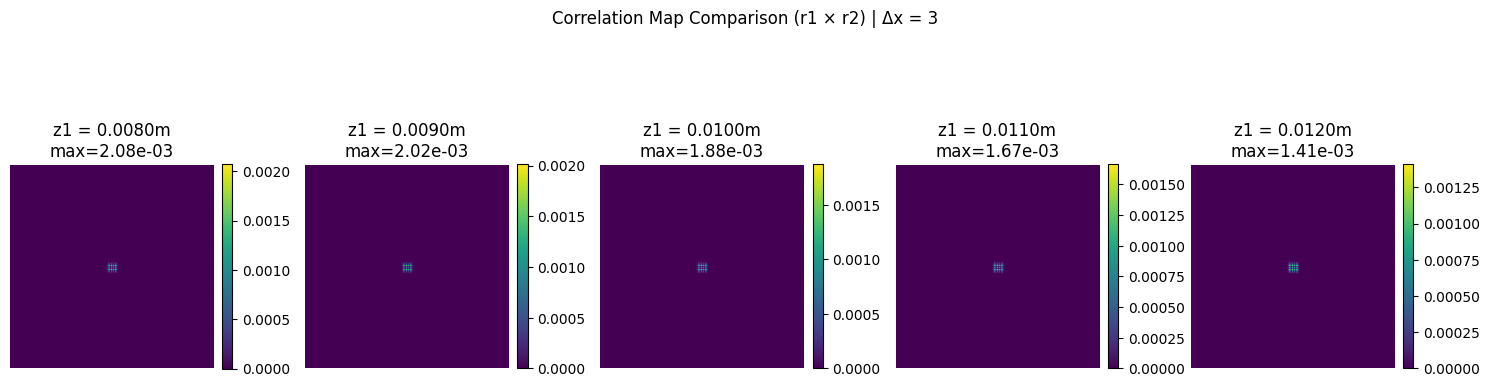

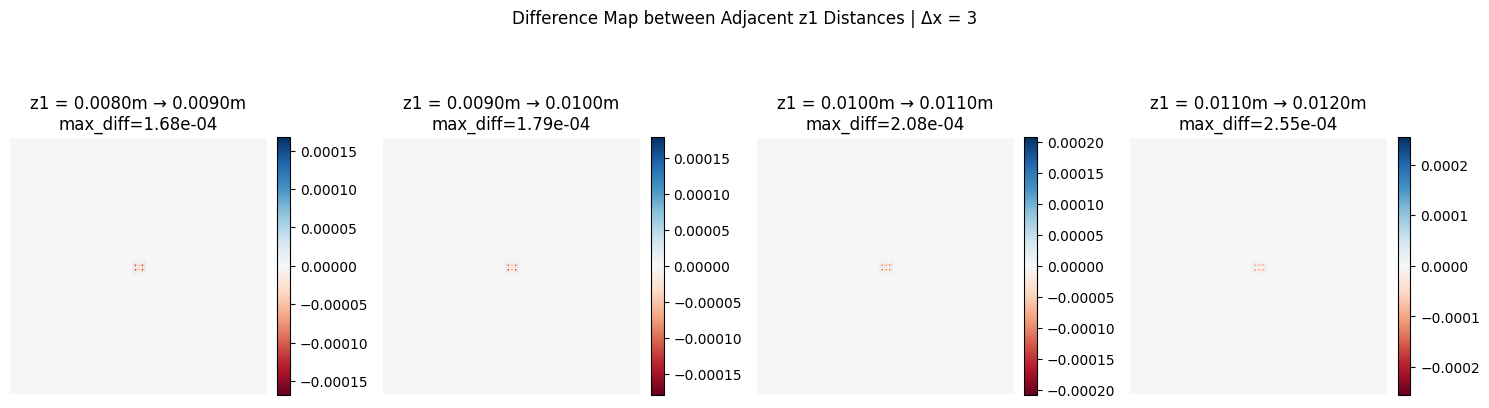

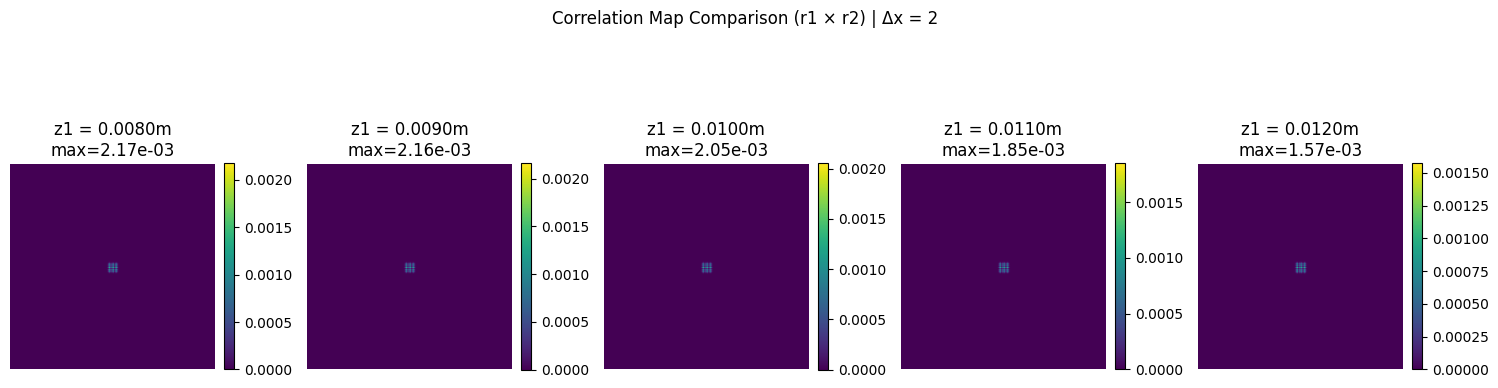

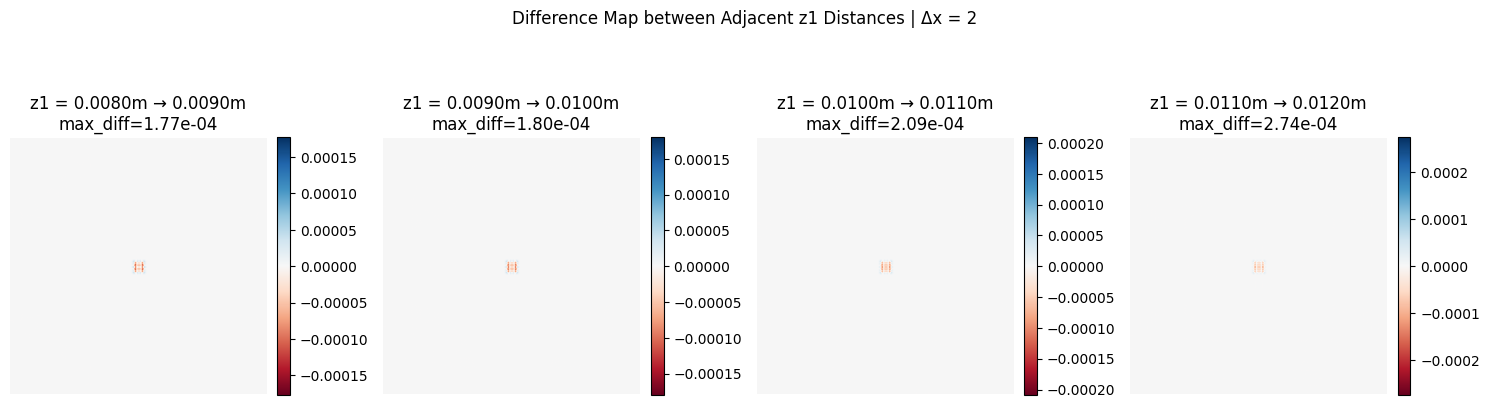

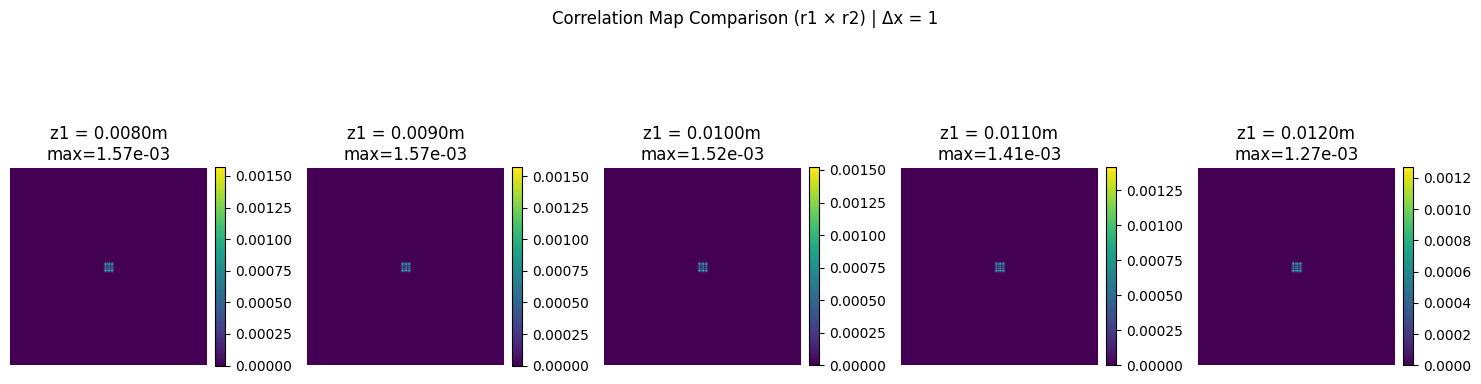

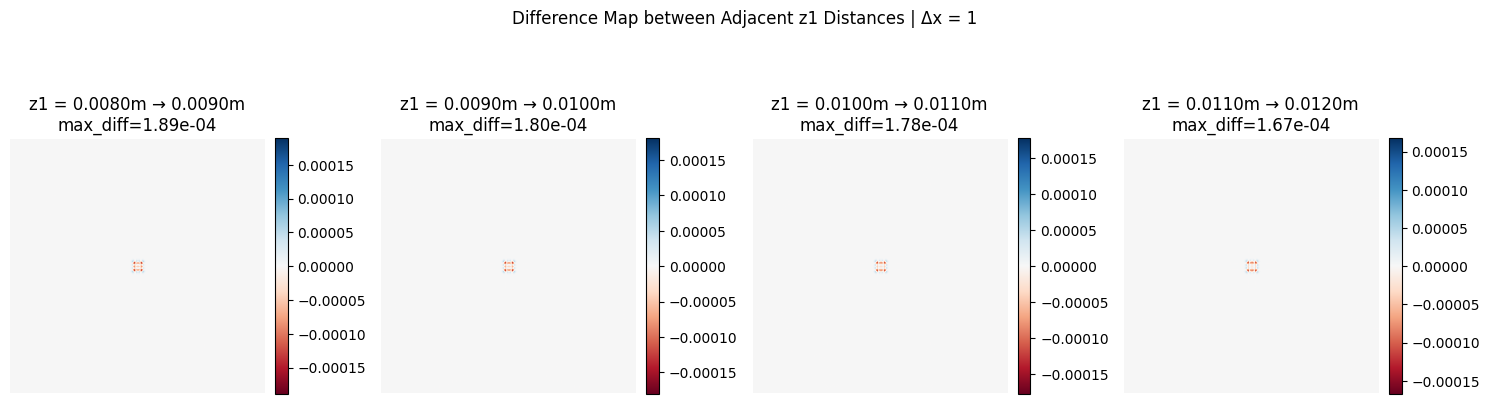

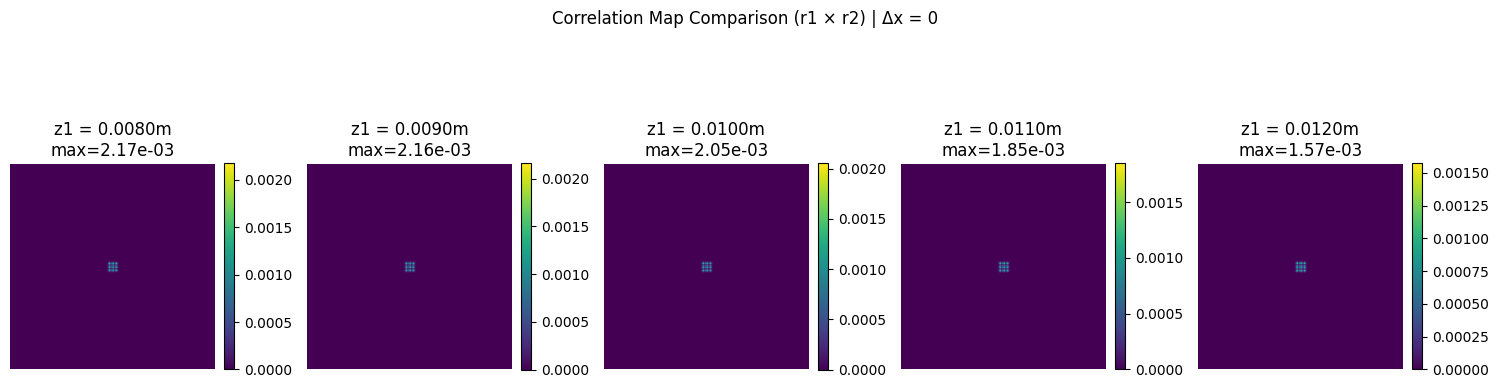

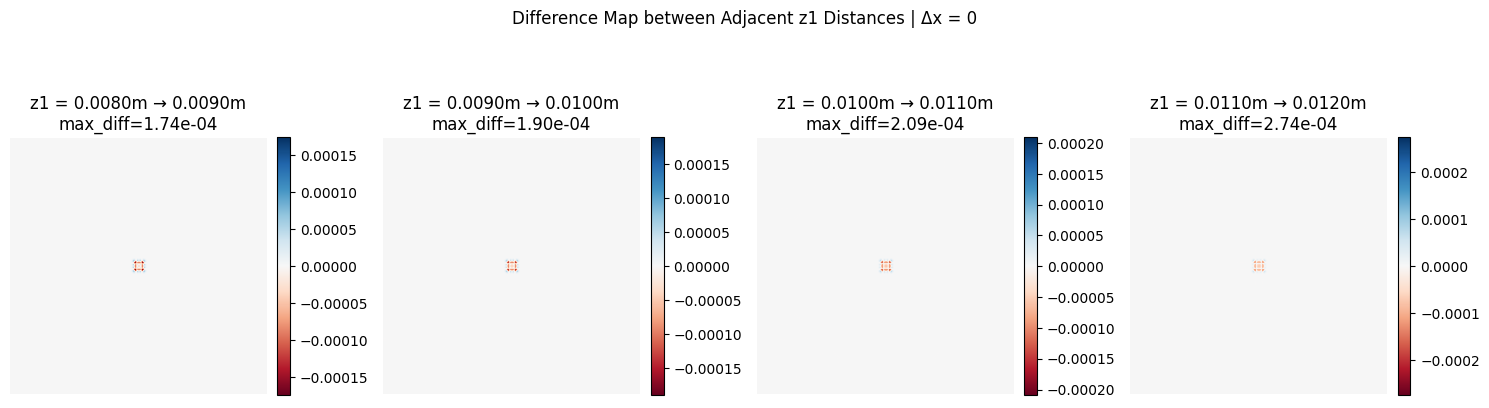


=== Correlation Map (r1 × r2) Analysis Results ===

Maximum correlation values for each z1 distance and Δx:
--------------------------------------------------------------------------------

z1 = 0.0080m:
  Δx |        Max |       Mean |        Std
------------------------------------------------------------
  30 |  2.580e-07 |  4.283e-10 |  7.228e-09
  29 |  3.731e-07 |  4.872e-10 |  8.230e-09
  28 |  4.720e-07 |  5.907e-10 |  1.017e-08
  27 |  5.178e-07 |  6.899e-10 |  1.176e-08
  26 |  7.963e-07 |  8.406e-10 |  1.525e-08
  25 |  1.007e-06 |  1.036e-09 |  1.896e-08
  24 |  9.847e-07 |  1.225e-09 |  2.183e-08
  23 |  1.324e-06 |  1.586e-09 |  2.875e-08
  22 |  1.675e-06 |  2.005e-09 |  3.746e-08
  21 |  2.368e-06 |  2.607e-09 |  4.911e-08
  20 |  2.996e-06 |  3.492e-09 |  6.691e-08
  19 |  3.927e-06 |  4.764e-09 |  9.185e-08
  18 |  5.422e-06 |  6.772e-09 |  1.345e-07
  17 |  9.501e-06 |  1.038e-08 |  2.203e-07
  16 |  1.754e-05 |  1.656e-08 |  3.847e-07
  15 |  3.331e-05 |  2.778e-08

In [4]:
import torch
import matplotlib.pyplot as plt
from torchOptics.optics import Tensor, propASM, applylens
import numpy as np

# === [Experiment Conditions] ===
wavelength = 632.8e-9  # m (e.g., HeNe laser)
grid_size = 256
dx = 50e-6  # m
f_plus = 0.15
f_minus = 0.25
meta = {'dx': (dx, dx), 'wl': (wavelength,)}

# === [GPU Settings] ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define source sample point (Thermal)
center_point = grid_size // 2
source_point = [(center_point, center_point)]

z1_min = 0.008
z1_max = 0.012
num_z1_steps = 5
z1_values_to_simulate = torch.linspace(z1_min, z1_max, num_z1_steps)

z2_fixed = 0.05

# Create coordinates for lens phase - move to GPU
x = torch.linspace(-grid_size//2, grid_size//2-1, grid_size) * dx
X, Y = torch.meshgrid(x, x, indexing='ij')
R2 = (X**2 + Y**2).to(device)

k = 2 * np.pi / wavelength

# Calculate lens phase terms
phase_term1 = torch.exp(1j * torch.tensor(k / (2 * f_plus), dtype=torch.complex64).to(device) * R2)
phase_term2 = torch.exp(1j * torch.tensor(k / (2 * f_minus), dtype=torch.complex64).to(device) * R2)
total_lens_phase_term = phase_term1 + phase_term2

# Loop over z1_eff values
all_z1_results = {}  # 각 z1 거리별 결과를 저장할 딕셔너리

for z1_eff in z1_values_to_simulate:
    # Initialize intensity map for incoherent sum
    total_intensity_at_detector = torch.zeros((grid_size, grid_size), dtype=torch.float32, device=device)

    # Source is always at the center
    center = grid_size // 2
    x1, y1 = center, center
    E0_template = torch.zeros((grid_size, grid_size), dtype=torch.complex64, device=device)
    E0_template[x1, y1] = 1.0 # Source field at the center
    E0 = Tensor(E0_template, meta)

    # Optical system propagation
    E1 = propASM(E0, float(z1_eff))
    E2 = E1 * total_lens_phase_term
    E3 = propASM(E2, float(z2_fixed))

    # Incoherent sum (intensity)
    intensity_from_point = torch.abs(E3)**2
    total_intensity_at_detector += intensity_from_point.squeeze(0)
    
    # 현재 z1 거리의 결과를 저장
    all_z1_results[float(z1_eff)] = total_intensity_at_detector.cpu().numpy()

# Δx를 20부터 0까지의 모든 값에 대해 비교
delta_x_values = list(range(30, -1, -1))  # 20부터 0까지의 모든 정수

# 각 Δx 값에 대해 z1 거리별 비교
for delta_x in delta_x_values:
    # 기존 상관관계 맵 비교
    fig, axes = plt.subplots(1, len(z1_values_to_simulate), figsize=(15, 5))
    fig.suptitle(f'Correlation Map Comparison (r1 × r2) | Δx = {delta_x}', fontsize=12)
    
    for idx, z1_eff in enumerate(z1_values_to_simulate):
        intensity_map_r1 = all_z1_results[float(z1_eff)]
        intensity_map_r2 = np.roll(intensity_map_r1, shift=delta_x, axis=0)
        correlation_map = intensity_map_r1 * intensity_map_r2
        
        im = axes[idx].imshow(correlation_map, cmap='viridis')
        axes[idx].set_title(f'z1 = {z1_eff:.4f}m\nmax={np.max(correlation_map):.2e}')
        axes[idx].axis('off')
        plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # 인접한 z1 거리 간의 차이 맵 비교
    fig_diff, axes_diff = plt.subplots(1, len(z1_values_to_simulate)-1, figsize=(15, 5))
    fig_diff.suptitle(f'Difference Map between Adjacent z1 Distances | Δx = {delta_x}', fontsize=12)
    
    for idx in range(len(z1_values_to_simulate)-1):
        z1_current = z1_values_to_simulate[idx]
        z1_next = z1_values_to_simulate[idx+1]
        
        # 현재 z1 거리의 상관관계 맵
        intensity_map_r1_current = all_z1_results[float(z1_current)]
        intensity_map_r2_current = np.roll(intensity_map_r1_current, shift=delta_x, axis=0)
        correlation_map_current = intensity_map_r1_current * intensity_map_r2_current
        
        # 다음 z1 거리의 상관관계 맵
        intensity_map_r1_next = all_z1_results[float(z1_next)]
        intensity_map_r2_next = np.roll(intensity_map_r1_next, shift=delta_x, axis=0)
        correlation_map_next = intensity_map_r1_next * intensity_map_r2_next
        
        # 차이 맵 계산
        diff_map = correlation_map_next - correlation_map_current
        
        # 시각화
        im_diff = axes_diff[idx].imshow(diff_map, cmap='RdBu', vmin=-np.max(np.abs(diff_map)), vmax=np.max(np.abs(diff_map)))
        axes_diff[idx].set_title(f'z1 = {z1_current:.4f}m → {z1_next:.4f}m\nmax_diff={np.max(np.abs(diff_map)):.2e}')
        axes_diff[idx].axis('off')
        plt.colorbar(im_diff, ax=axes_diff[idx], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# 각 z1 거리와 Δx 값에 대한 상관관계 분석
print("\n=== Correlation Map (r1 × r2) Analysis Results ===")
print("\nMaximum correlation values for each z1 distance and Δx:")
print("-" * 80)

for z1_eff in sorted(all_z1_results.keys()):
    print(f"\nz1 = {z1_eff:.4f}m:")
    print(f"{'Δx':>4} | {'Max':>10} | {'Mean':>10} | {'Std':>10}")
    print("-" * 60)
    
    for delta_x in delta_x_values:
        intensity_map_r1 = all_z1_results[float(z1_eff)]
        intensity_map_r2 = np.roll(intensity_map_r1, shift=delta_x, axis=0)
        correlation_map = intensity_map_r1 * intensity_map_r2
        
        max_val = np.max(correlation_map)
        mean_val = np.mean(correlation_map)
        std_val = np.std(correlation_map)
        
        print(f"{delta_x:4d} | {max_val:10.3e} | {mean_val:10.3e} | {std_val:10.3e}")

# 인접한 z1 거리 간의 차이 분석
print("\n=== Difference Analysis between Adjacent z1 Distances ===")
print("\nMaximum differences between adjacent z1 distances for each Δx:")
print("-" * 80)

for i in range(len(z1_values_to_simulate)-1):
    z1_current = z1_values_to_simulate[i]
    z1_next = z1_values_to_simulate[i+1]
    print(f"\nz1 = {z1_current:.4f}m → {z1_next:.4f}m:")
    print(f"{'Δx':>4} | {'Max Diff':>10} | {'Mean Diff':>10} | {'Std Diff':>10}")
    print("-" * 60)
    
    for delta_x in delta_x_values:
        # 현재 z1 거리의 상관관계 맵
        intensity_map_r1_current = all_z1_results[float(z1_current)]
        intensity_map_r2_current = np.roll(intensity_map_r1_current, shift=delta_x, axis=0)
        correlation_map_current = intensity_map_r1_current * intensity_map_r2_current
        
        # 다음 z1 거리의 상관관계 맵
        intensity_map_r1_next = all_z1_results[float(z1_next)]
        intensity_map_r2_next = np.roll(intensity_map_r1_next, shift=delta_x, axis=0)
        correlation_map_next = intensity_map_r1_next * intensity_map_r2_next
        
        # 차이 맵
        diff_map = correlation_map_next - correlation_map_current
        
        max_diff = np.max(np.abs(diff_map))
        mean_diff = np.mean(np.abs(diff_map))
        std_diff = np.std(diff_map)
        
        print(f"{delta_x:4d} | {max_diff:10.3e} | {mean_diff:10.3e} | {std_diff:10.3e}")

print("\nAnalysis completed.")